## Neural mass computational model to test effect of task on functional connectivity estimates

Code for running the neural mass simulation from: Cole MW, Ito T, Schultz D, Mill R, Chen R, Cocuzza C (2019). "Task activations produce spurious but systematic inflation of task functional connectivity estimates". NeuroImage. doi:10.1016/j.neuroimage.2018.12.054 https://authors.elsevier.com/a/1YNWs3lc~r3Jbx https://doi.org/10.1016/j.neuroimage.2018.12.054

Outline of procedures:
- Create a simple rate code neural network model with biologically-interpretable parameters
- Specify a structural connectivity matrix for network with 4 network communities
- Specify random synaptic weights on the connectivity network
- Simulate resting-state activity as random activity in model 
- Simulate fMRI data collection: Convolve LFP time series with HRF, then downsample
- Simulate evoked activity in model
- Test effects of fMRI simulation on rest vs. task FC differences
- Test effects of correction procedures on task-activation-driven distortions of task FC


#### Mathematical formalization of model

$$u_i (t) = f_i\Big( I_i + bias \Big) \quad i=[1..n] \qquad \qquad (1)$$

where $u_i$ is the output activity (population spike rate) for unit $i$ at time $t$, $I_i$ is the input (population field potential) as defined below, and $bias$ is the bias (population resting potential, or excitability).

$$I_i(t) = \sum_{j=1}^n G w_{ij} u_j(t-1) + d_i + stim_i \qquad \qquad (2)$$

where $I_i(t)$ is the input (population field potential) for unit $i$ at time $t$, $G$ is the global coupling parameter (a scalar influencing all connection strengths), $w_{ij}$ is the synaptic weight from unit $j$ to $i$, $u_{j}(t-1)$ is the output activity from unit $j$ at the previous timestep, $d_i$ is spontaneous activity (a Gaussian random value), and $stim_i$ is task stimulation (if any).

Initial condition is set to a Gaussian random value (mean 0, standard deviation 1) as input for all units at timepoint 0.

The sigmoid $f(x)$ (population threshold):
$$f(x) = \frac{1}{1-e^{-x}}  \qquad \qquad (3)$$

Settings for model:
$d_i$ is a Gaussian random value with mean 0 and standard deviation 3, G is set to 5, all inter-unit connections are normalized so they sum to 1, and all self-connections (diagonals in $w$) are set to 1. Setting the self-connection above 0 reflects the theoretical neurons within the modeled neural population having synaptic connections among each other, such that the same outputs sent to other units also affect the unit that sent it. See the Cole et al. (2019) paper for more details.

In [1]:
#Basic variables

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import os.path
from functools import partial

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams.update({'font.size': 16})
plt.rcParams['image.aspect'] = 'equal'
import multiprocessing as mp
numWorkers=mp.cpu_count()
print("Number of CPU cores available: "+str(numWorkers))
numWorkers=int(round(numWorkers/2))
print("Number of CPU cores being used: "+str(numWorkers))

Number of CPU cores available: 16
Number of CPU cores being used: 8


<ipython-input-1-29956351a09b>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
numRegions=300
def createSynapticMatrix(numRegions=numRegions):
    #Creating network model with random connectivity, 10% density with random synaptic strengths
    structConnVector=np.random.uniform(0,1,(numRegions,numRegions))>.90
    #Add self-connections (important if adding autocorrelation later)
    np.fill_diagonal(structConnVector,10)
    #Create modular structural network (3 modules)
    numModules=3
    numRPerModule=int(round(numRegions/numModules))
    lastModuleNode=-1
    for moduleNum in range(0,numModules):
        for thisNodeNum in range(lastModuleNode+1,lastModuleNode+numRPerModule+1):    
            #Set this node to connect to 10 random other nodes in module
            for i in range(1,numRPerModule//2):
                randNodeInModule=int(np.random.uniform(lastModuleNode+1,lastModuleNode+numRPerModule+1,(1,1)))
                structConnVector[thisNodeNum,randNodeInModule]=1
        lastModuleNode=lastModuleNode+numRPerModule

    #Adding synaptic weights to existing structural connections (small random synapse strength variation)
    synapticWeightVector=structConnVector*(1+np.random.standard_normal((numRegions,numRegions))*.001)

    #Adding synaptic mini-communities (within community 1)
    synapticWeightVector[0:50,50:100]=synapticWeightVector[0:50,50:100]*-0.2
    synapticWeightVector[50:100,0:50]=synapticWeightVector[50:100,0:50]*-0.2
    synapticWeightVector[0:50,0:50]=synapticWeightVector[0:50,0:50]*1.2
    synapticWeightVector[50:100,50:100]=synapticWeightVector[50:100,50:100]*1.2
    
    #MODIFICATION: 0 connectivity between structural community 1 and 3
    synapticWeightVector[0:100,200:300]=synapticWeightVector[0:100,200:300]*0
    synapticWeightVector[200:300,0:100]=synapticWeightVector[200:300,0:100]*0
    synapticWeightVector[100:200,200:300]=synapticWeightVector[100:200,200:300]*0
    synapticWeightVector[200:300,100:200]=synapticWeightVector[200:300,100:200]*0
    
    #Normalize each region's inputs to have a mean of 1/k, where k is the number of incoming connections (in degree)
    #Based on Barral, J. & Reyes, A. D. Synaptic scaling rule preserves excitatory-inhibitory balance and salient neuronal network dynamics. Nat. Neurosci. (2016)
    #This ensures that all inputs into each node sum to 1
    for nodeNum in range(numRegions):
        k=np.sum(synapticWeightVector[nodeNum,:])
        if k>0:
            synapticWeightVector[nodeNum,:]=np.divide(synapticWeightVector[nodeNum,:],k)
    
    return synapticWeightVector


(300, 300)


[Text(0, 0, '0'),
 Text(0, 100, '100'),
 Text(0, 200, '200'),
 Text(0, 299, '300')]

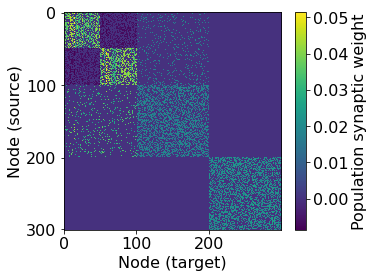

In [6]:
plt.figure(figsize=(5,4))
synapticWeightVector=createSynapticMatrix()
print(np.shape(synapticWeightVector))
plt.imshow(np.transpose(synapticWeightVector))
cbar=plt.colorbar()
cbar.set_label('Population synaptic weight')
plt.xlabel('Node (target)')
plt.ylabel('Node (source)')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
#plt.savefig('ActflowSim_StructuralMat.pdf',dpi=600,transparent=True, bbox_inches='tight')

In [7]:
#Set up code for neural mass model

#Define sigmoid activation function
def sigmoid(x): return 1 / (1 + np.exp(-x))

# Specify simulation length
#At 50ms time steps, 24600 time steps = 20.5 minutes of data
numTimePoints=24600

def networkModel(subjNum=1, G=1.0, Indep=1.0, numTimePoints=numTimePoints, stimTimes=np.array([0]), stimRegions=np.array([0]), biasParam=-20):
    """
    Network model simulation
    """
    np.random.seed(subjNum)
    
    numRegions=300
    synapticWeightVector=createSynapticMatrix(numRegions)
    
    #Set up dictionary for output
    outputdata={'simulatedTimeseries':np.zeros((numTimePoints,numRegions)),'simulatedTimeseriesInputs':np.zeros((numTimePoints,numRegions)),'subjNum':subjNum, 'synapticWeightVector':synapticWeightVector}
    
    spontActLevel=3
    
    ## Static model parameters
    G = np.float64(G)
    Indep = np.float64(Indep)
    ## Begin simulation set-up
    # Empty matrix for simulated timeseries
    simulatedTimeseries=np.zeros((numTimePoints,numRegions))
    #Track sigmoid input dynamics
    simulatedTimeseriesInputs=np.zeros((numTimePoints,numRegions))
    
    # Select bias parameter for all ROIs
    #Bias shifts all inputs to regions, with negative values making reaching "threshold" less likely
    #Equivalent to aggregate resting potentials of neurons in population
    bias = np.zeros(shape=(numRegions,))
    #Only apply bias to excitatory units
    bias[range(numRegions)]=biasParam
    #K is the slope of the sigmoid curve
    k=1
    
    #Note: Each state modifies previous state (creating some autocorrelation; pink noise); modulated by Indep parameter
    autocorr=0.0
    #This is set to 0 because self-connections already create autocorrelation (and associated pink noise)
    
    # Modulate synaptic weight matrix by coupling parameter, G
    GlobalCouplingMat = synapticWeightVector*G
    np.fill_diagonal(GlobalCouplingMat,0)
    # Modulate self connection 'independence' parameter, Indep
    IndepVarMat = np.identity(numRegions)*Indep
    
    # Now reconstruct synapticWeightMatrix
    synapticWeightVector = GlobalCouplingMat + IndepVarMat
    
    # Begin computing simulation
    for thisTimePoint in range(0,numTimePoints):
        stimActVector=np.zeros(numRegions)
        if thisTimePoint==0:
            # Generate spontaneous activity for initial state
            actVector=sigmoid(k*(bias + np.random.normal(0,spontActLevel,(numRegions,))))
            inputActivity=np.zeros(numRegions)
        else:
            #Bring outputs from previous time point as inputs for this timepoint
            actVector=outputvect
        
        #Calculate inputs from other nodes
        actVectorToMat = np.kron(np.ones((numRegions,1)),actVector)
        inputActivity = np.multiply(autocorr,inputActivity) + np.sum(np.multiply(actVectorToMat,synapticWeightVector), axis=1)
        
        # Specify spontaneous input activity at this time point and task activity
        if np.any(stimRegions != 0):
            if thisTimePoint in stimTimes:
                #Include moment-to-moment variability in task stimulation, separate for each region
                stimAct=np.ones(len(stimRegions))*0.3
                stimActVector[stimRegions]=stimAct
        #Add task stimulus (all 0s for rest)
        inputActivity=inputActivity+stimActVector
        # Add spontaneous activity vector (internal state of unit)
        inputActivity=inputActivity+np.random.normal(0,spontActLevel,(numRegions,))
        #Record input activity
        outputdata['simulatedTimeseriesInputs'][thisTimePoint,]=inputActivity
        
        #Calculate outputs
        outputvect = sigmoid(k*(bias + inputActivity))
        outputdata['simulatedTimeseries'][thisTimePoint,] = outputvect
        
    return outputdata


#Implement global coupling parameter
G=5
#Implement local independence parameter
Indep=5
G=np.float64(G)
Indep=np.float64(Indep)
biasParam=-5
numSubjs=24
subjNumList=range(0,numSubjs)


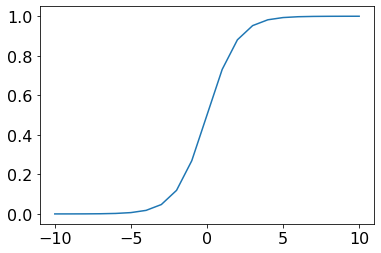

In [8]:
#Plotting the sigmoid activation function being used

k=1 #k is the steepness of the sigmoid
bias=0
inputList=range(-10,11)
plt.plot(inputList,sigmoid(k*(np.array(inputList)+bias)))


In [14]:
output = networkModel(numTimePoints=100)
output.keys()

dict_keys(['simulatedTimeseries', 'simulatedTimeseriesInputs', 'subjNum', 'synapticWeightVector'])

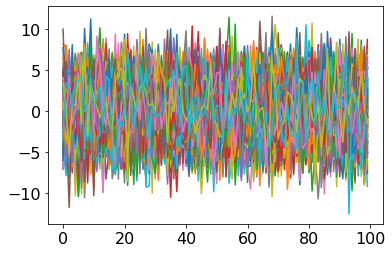

In [15]:
plt.plot(output['simulatedTimeseriesInputs']);

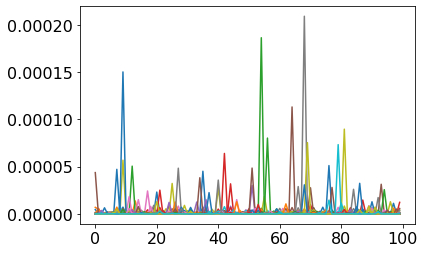

In [13]:
plt.plot(output['simulatedTimeseries']);

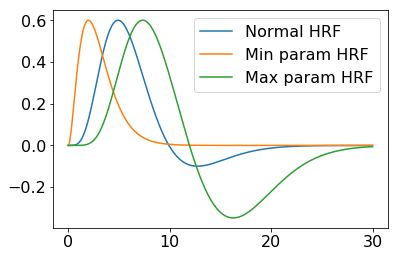

In [ ]:
#Prepare to simulate fMRI data collection
#Based on http://www.jarrodmillman.com/rcsds/lectures/convolution_background.html

#Creating a hemodynamic response function
#Varying across regions and subjects to model HRF variability (Handwerker et al., 2004)

from scipy.stats import gamma

def hrf(times,peakscale=0.6,peaktime=6,undershoottime=12,undershootratio=.35):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, peaktime)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, undershoottime)
    # Combine them
    values = peak_values - undershootratio * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * peakscale

simsample_rate=0.05 #Every 50ms
simsample_times = np.arange(0, 30, simsample_rate)
hrf_at_simsample = hrf(simsample_times,0.6,6,12,.35)
#hrf_at_simsample = hrf(simsample_times,0.6,8.5,3,.1)
plt.figure()
plt.plot(simsample_times, hrf_at_simsample,label='Normal HRF')

peaktimes=np.arange(3,9,.5)
undershoottimes=np.arange(3,17,.5)
undershootratios=np.arange(0,1,.1)

peakscale_min=.6
peaktime_min=min(peaktimes)
undershoottime_min=min(undershoottimes)
undershootratio_min=min(undershootratios)
hrf_at_simsample_min = hrf(simsample_times,peakscale_min,peaktime_min,undershoottime_min,undershootratio_min)
plt.plot(simsample_times, hrf_at_simsample_min,label='Min param HRF')

peakscale_max=.6
peaktime_max=max(peaktimes)
undershoottime_max=max(undershoottimes)
undershootratio_max=max(undershootratios)
hrf_at_simsample_max = hrf(simsample_times,peakscale_max,peaktime_max,undershoottime_max,undershootratio_max)
plt.plot(simsample_times, hrf_at_simsample_max,label='Max param HRF')
plt.legend()



In [ ]:
#Convolve simulated time series with HRF

#Should be more variability between subjects than between regions:
#A starting-point HRF shape is generated for each subject, with smaller variations across regions (within subject)

# Run multiprocessing across subjects
#randValsForSeeds=np.random.randint(0,1000000,size=len(subjNumList))
randValsForSeeds=np.array([465270, 736283, 805414, 982843, 869872, 599374, 681179, 809998,
       529357,  71357,  13757, 590842, 487281, 572480, 985935, 244051,
       425660, 588702, 708734, 348506, 221837,  56924, 805108, 448428])


#inputs = []
#for subjNum in subjNumList: inputs.append((subjNum,output_rest_bysubj[subjNum]['simulatedTimeseriesInputs']))

    
def convolveBySubj_varHRF(inputs):
    
    subjNum=inputs[0]
    np.random.seed(randValsForSeeds[subjNum])
    hrfParams_byRegion=np.zeros((3,numRegions))
    
    #Select which HRF to start from for this subject
    peaktimeInd_thissubj=np.random.randint(len(peaktimes))
    undershoottimeInd_thissubj=np.random.randint(len(undershoottimes))
    undershootratioInd_thissubj=np.random.randint(len(undershootratios))
    
    simulatedRestTimeseriesSubj=inputs[1]
    simulatedTimeseries_convolved=np.zeros(np.shape(simulatedRestTimeseriesSubj))
    
    #Set up dictionary for output
    outputdata={'simulatedTimeseries_convolved':np.zeros(np.shape(simulatedRestTimeseriesSubj)),'subjNum':subjNum, 'peaktimeInd_thissubj':peaktimeInd_thissubj, 'undershoottimeInd_thissubj':undershoottimeInd_thissubj, 'undershootratioInd_thissubj':undershootratioInd_thissubj, 'hrfParams_byRegion':np.zeros(np.shape(hrfParams_byRegion))}
        
    for regionNum in range(0,numRegions):
        
        #Select which HRF for this region (normal distribution on all 3 parameters with stdev of 1)
        stdevVal=1
        peaktime_randInd=max(0,min(len(peaktimes)-1,peaktimeInd_thissubj+np.int(np.random.normal(0,stdevVal))))
        peaktime_thisregion=peaktimes[peaktime_randInd]
        undershoottime_randInd=max(0,min(len(undershoottimes)-1,undershoottimeInd_thissubj+np.int(np.random.normal(0,stdevVal))))
        undershoottime_thisregion=undershoottimes[undershoottime_randInd]
        undershootratio_randInd=max(0,min(len(undershootratios)-1,undershootratioInd_thissubj+np.int(np.random.normal(0,stdevVal))))
        undershootratio_thisregion=undershootratios[undershootratio_randInd]
        
        hrfParams_byRegion[0,regionNum]=peaktime_thisregion
        hrfParams_byRegion[1,regionNum]=undershoottime_thisregion
        hrfParams_byRegion[2,regionNum]=undershootratio_thisregion
        
        this_hrf_at_simsample = hrf(simsample_times,0.6,peaktime_thisregion,undershoottime_thisregion,undershootratio_thisregion)
        convolved = np.convolve(simulatedRestTimeseriesSubj[:,regionNum], this_hrf_at_simsample)
        n_to_remove = len(this_hrf_at_simsample) - 1
        convolved = convolved[:-n_to_remove]
        simulatedTimeseries_convolved[:,regionNum]=convolved
        
    outputdata['simulatedTimeseries_convolved'] = simulatedTimeseries_convolved
    outputdata['hrfParams_byRegion'] = hrfParams_byRegion
    return outputdata

def ttestFCByRegionVs0(fcMat1):
    numRegions = np.shape(fcMat1[0])[0]
    fcMat_tvals=np.zeros((numRegions,numRegions))
    fcMat_pvals=np.ones((numRegions,numRegions))
    for region1 in range(numRegions):
        for region2 in range(numRegions):
            if region1 != region2:
                fcVal1BySubj=[fcMat1[subjNum][region1,region2] for subjNum in subjNumList]
                [fcMat_tvals[region1,region2],fcMat_pvals[region1,region2]]=stats.ttest_1samp(fcVal1BySubj,0.0)
    return fcMat_tvals,fcMat_pvals




# Task-evoked activity simulation

In [ ]:
#Simulate random activity in model, WITH TASK-EVOKED STIMULATION (sum of activity weighted by synapses)
#First and third runs are tasks, with the second being resting state (no external stimulation)
numTasks=3

#6 task blocks of 2.5 minutes each (with 30 seconds rest before and after each task block); 2nd task is rest (no stim)
stimTimes=np.concatenate((range(600,3600),range(4200,7200),range(7800,10800),range(11400,14400),range(15000,18000),range(18600,21600)),axis=0)
#Creating timing with 4 events within each block, fixed 200ms (4 time point) delays between each. This is to be more realistic by including brief breaks between stimuli (as is typical in cognitive designs) even though we'll model it as a block design.
stimTimes_actualpresentationtimes=np.concatenate((range(600,1346),range(1350,2096),range(2100,2846),range(2850,3600),
                                                  range(3600+600,3600+1346),range(3600+1350,3600+2096),range(3600+2100,3600+2846),range(3600+2850,3600+3600)
                                                  ,range(7200+600,7200+1346),range(7200+1350,7200+2096),range(7200+2100,7200+2846),range(7200+2850,7200+3600)
                                                  ,range(10800+600,10800+1346),range(10800+1350,10800+2096),range(10800+2100,10800+2846),range(10800+2850,10800+3600)
                                                  ,range(14400+600,14400+1346),range(14400+1350,14400+2096),range(14400+2100,14400+2846),range(14400+2850,14400+3600)
                                                  ,range(18000+600,18000+1346),range(18000+1350,18000+2096),range(18000+2100,18000+2846),range(18000+2850,18000+3600)
                                                  ,range(18000+600,18000+1346),range(18000+1350,18000+2096),range(18000+2100,18000+2846),range(18000+2850,18000+3600))
                                                  ,axis=0)
#At 50ms time steps, 24600 time steps = 20.5 minutes of data
numTimePoints=24600
#Specify which regions are stimulated for each task. Task 0 is main task, Task 1 is rest (no stimulation), Task 2 is like Task 0 except with half the regions stimulated.
stimRegionsByTask=np.array((np.concatenate((range(24,50),range(274,300))),np.array([0]),range(24,50)))
simulatedTimeseriesTaskStim=np.zeros((numTimePoints,numRegions,numTasks))
simulatedTimeseriesTaskStim_inputs=np.zeros((numTimePoints,numRegions,numTasks))
simulatedTimeseriesTaskStim_bysubj=np.zeros((len(subjNumList),numTimePoints,numRegions,numTasks))
simulatedTimeseriesTaskStim_inputs_bysubj=np.zeros((len(subjNumList),numTimePoints,numRegions,numTasks))

for taskNum in range(numTasks):
    print('Running task '+str(taskNum))
    
    stimRegions=stimRegionsByTask[taskNum]
    
    # Run multiprocessing across subjects
    networkModel_partial=partial(networkModel,G=G,Indep=Indep,numTimePoints=numTimePoints,stimTimes=stimTimes_actualpresentationtimes,stimRegions=stimRegions,biasParam=biasParam)
    pool = mp.Pool(processes=numWorkers)
    output_task_bysubj = pool.map_async(networkModel_partial, subjNumList).get()
    pool.close()
    pool.join()

    #Save data for each task
    simulatedTimeseriesTaskStim_bysubj[:,:,:,taskNum]=[output_task_bysubj[subjNum]['simulatedTimeseries'] for subjNum in subjNumList]
    simulatedTimeseriesTaskStim_inputs_bysubj[:,:,:,taskNum]=[output_task_bysubj[subjNum]['simulatedTimeseriesInputs'] for subjNum in subjNumList]
    #First subject only
    simulatedTimeseriesTaskStim[:,:,taskNum]=output_task_bysubj[0]['simulatedTimeseries']
    simulatedTimeseriesTaskStim_inputs[:,:,taskNum]=output_task_bysubj[0]['simulatedTimeseriesInputs']


Running task 0
Running task 1
Running task 2


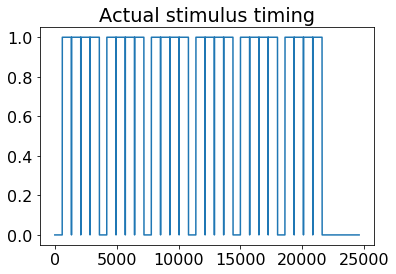

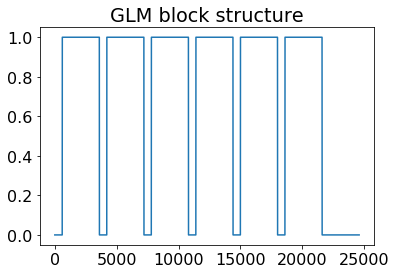

In [ ]:
times=np.zeros(24600)
times[stimTimes_actualpresentationtimes]=1
plt.plot(times)
plt.title('Actual stimulus timing')

taskTimingVect1=np.zeros(numTimePoints)
taskTimingVect1[stimTimes]=1
plt.figure()
plt.plot(taskTimingVect1)
plt.title('GLM block structure')



('Percentage of FCs that are increases: ', 89, '%')
('Percentage of FCs that are decreases: ', 10, '%')


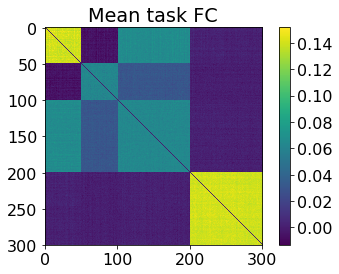

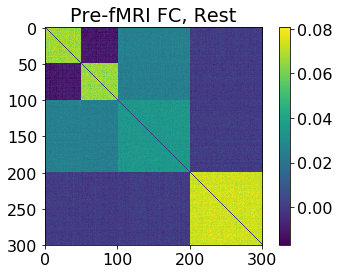

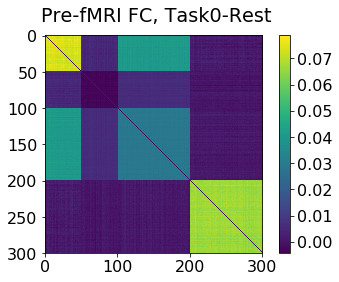

In [ ]:
#Produce task FC matrix based on produced time series, pre-fMRI

def createFCMatBySubj_SingleTask(timeseriesData,taskNum):
    subjNumList=range(len(timeseriesData))
    return [np.corrcoef(timeseriesData[subjNum][10:,:,taskNum],rowvar=0) for subjNum in subjNumList]

## Assumed-shape HRF version

#Run for all tasks
fcMat_taskActFC_preFMRI_bysubj_bytask=[createFCMatBySubj_SingleTask(simulatedTimeseriesTaskStim_inputs_bysubj[:,stimTimes,:,:],taskNum) for taskNum in range(numTasks)]

fcMat_taskActFC_mean=np.mean(fcMat_taskActFC_preFMRI_bysubj_bytask[0],axis=0)
np.fill_diagonal(fcMat_taskActFC_mean,0)
plt.imshow(fcMat_taskActFC_mean)
plt.colorbar()
plt.title('Mean task FC')
#plt.savefig('ActflowSim_Task0PREfMRI_FCMat.pdf',dpi=600,transparent=True, bbox_inches='tight')

#fcMat_rest_preFMRI=np.corrcoef(simulatedRestTimeseries[10:,:],rowvar=0)
fcMat_rest_preFMRI_mean=np.mean(fcMat_taskActFC_preFMRI_bysubj_bytask[1],axis=0)
np.fill_diagonal(fcMat_rest_preFMRI_mean,0)
plt.figure()
plt.imshow(fcMat_rest_preFMRI_mean)
plt.title('Pre-fMRI FC, Rest')
plt.colorbar()
fig=plt.figure()
fig.suptitle("Pre-fMRI FC, Task0-Rest")
plt.imshow(fcMat_taskActFC_mean - fcMat_rest_preFMRI_mean)
plt.colorbar()
#plt.savefig('ActflowSim_Task0vsRestPREfMRI_FCMat.pdf',dpi=600,transparent=True, bbox_inches='tight')

fcMat_TaskStim_preFMRI_TaskVsRestTask0=fcMat_taskActFC_mean - fcMat_rest_preFMRI_mean
percentIncreases=100*sum(sum(fcMat_TaskStim_preFMRI_TaskVsRestTask0>0))/(np.shape(fcMat_TaskStim_preFMRI_TaskVsRestTask0)[0]*np.shape(fcMat_TaskStim_preFMRI_TaskVsRestTask0)[1])
print("Percentage of FCs that are increases: ", percentIncreases, "%")
percentDecreases=100*sum(sum(fcMat_TaskStim_preFMRI_TaskVsRestTask0<0))/(np.shape(fcMat_TaskStim_preFMRI_TaskVsRestTask0)[0]*np.shape(fcMat_TaskStim_preFMRI_TaskVsRestTask0)[1])
print("Percentage of FCs that are decreases: ", percentDecreases, "%")

def ttestFCByRegion(fcMat1,fcMat2):
    numRegions = np.shape(fcMat1[0])[0]
    fcMat_tvals=np.zeros((numRegions,numRegions))
    fcMat_pvals=np.ones((numRegions,numRegions))
    for region1 in range(numRegions):
        for region2 in range(numRegions):
            if region1 != region2:
                fcVal1BySubj=[fcMat1[subjNum][region1,region2] for subjNum in subjNumList]
                fcVal2BySubj=[fcMat2[subjNum][region1,region2] for subjNum in subjNumList]
                [fcMat_tvals[region1,region2],fcMat_pvals[region1,region2]]=stats.ttest_rel(fcVal1BySubj,fcVal2BySubj)
    return fcMat_tvals,fcMat_pvals



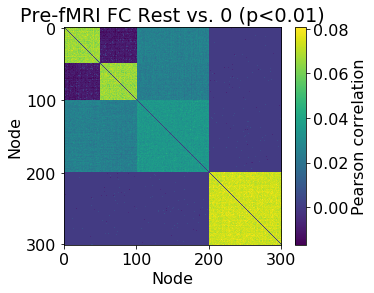

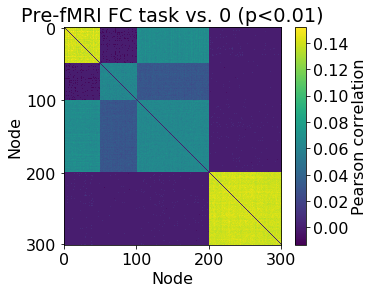

In [ ]:
#Calcultating t-stat matrices for task vs. 0 and rest vs. 0

def ttestFCByRegionVS0(fcMat1):
    numRegions = np.shape(fcMat1[0])[0]
    fcMat_tvals=np.zeros((numRegions,numRegions))
    fcMat_pvals=np.ones((numRegions,numRegions))
    for region1 in range(numRegions):
        for region2 in range(numRegions):
            if region1 != region2:
                fcVal1BySubj=[fcMat1[subjNum][region1,region2] for subjNum in subjNumList]
                [fcMat_tvals[region1,region2],fcMat_pvals[region1,region2]]=stats.ttest_1samp(fcVal1BySubj,0)
    return fcMat_tvals,fcMat_pvals

#Rest vs. 0 t-tests
[fcMat_tvals_PrefMRI_Restvs0,fcMat_pvals_PrefMRI_Restvs0]=ttestFCByRegionVS0(fcMat_taskActFC_preFMRI_bysubj_bytask[1])

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rest_preFMRI_mean*(fcMat_pvals_PrefMRI_Restvs0<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("Pre-fMRI FC Rest vs. 0 (p<0.01)")
plt.savefig('FCMat_preFMRI_restVS0_p01.pdf',dpi=600,transparent=True, bbox_inches='tight')

#Task vs. 0 t-tests
[fcMat_tvals_PrefMRI_t0vs0,fcMat_pvals_PrefMRI_t0vs0]=ttestFCByRegionVS0(fcMat_taskActFC_preFMRI_bysubj_bytask[0])

plt.figure(figsize=(5,4))
plt.imshow(fcMat_taskActFC_mean*(fcMat_pvals_PrefMRI_t0vs0<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("Pre-fMRI FC task vs. 0 (p<0.01)")
plt.savefig('FCMat_preFMRI_taskVS0_p01.pdf',dpi=600,transparent=True, bbox_inches='tight')

amountTaskFCInc: 0.138205617019


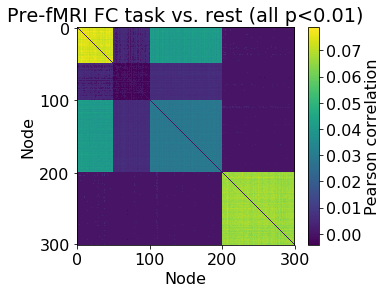

In [ ]:
#Calculating task vs. rest FC change

[fcMat_tvals_PrefMRI_t0vsRest,fcMat_pvals_PrefMRI_t0vsRest]=ttestFCByRegion(fcMat_taskActFC_preFMRI_bysubj_bytask[0],fcMat_taskActFC_preFMRI_bysubj_bytask[1])


plt.figure(figsize=(5,4))
plt.imshow(fcMat_TaskStim_preFMRI_TaskVsRestTask0*(fcMat_pvals_PrefMRI_t0vsRest<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("Pre-fMRI FC task vs. rest (all p<0.01)")
plt.savefig('FCMat_preFMRI_taskVSRest_p01.pdf',dpi=600,transparent=True, bbox_inches='tight')

amountTaskFCInc=np.mean(np.mean(fcMat_taskActFC_mean[0:50,0:50]-fcMat_rest_preFMRI_mean[0:50,0:50]))+np.mean(np.mean(fcMat_taskActFC_mean[200:299,200:299]-fcMat_rest_preFMRI_mean[200:299,200:299]))
print('amountTaskFCInc: ' + str(amountTaskFCInc))

(5, 560)


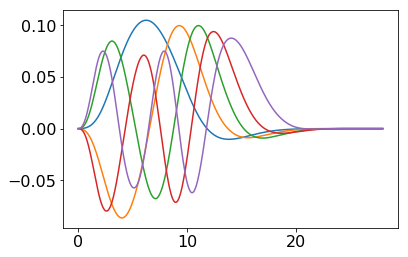

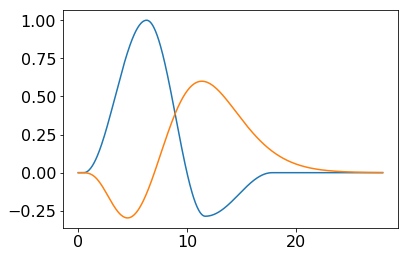

In [ ]:
#Simulate fMRI data collection
#Based on http://www.jarrodmillman.com/rcsds/lectures/convolution_background.html

#Creating a hemodynamic response function

from scipy.stats import gamma

def hrf_simwrong(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 12)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 6)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

hrf_50msRes=[0,0,0,0,0,0,0,0,0,0,0,0.000146435,0.000661035,0.0015457,0.002799777,0.004422334,0.006412171,0.008767813,0.011487508,0.014569249,0.018010754,0.021809459,0.025962554,0.030466976,0.035319362,0.040516142,0.046053439,0.05192716,0.058132969,0.064666234,0.071522146,0.078695588,0.086181261,0.093973666,0.102066942,0.110455133,0.11913202,0.128091171,0.137325987,0.146829546,0.156594843,0.166614696,0.176881567,0.187387914,0.198125929,0.20908767,0.220265076,0.231649727,0.243233264,0.255007088,0.266962498,0.279090643,0.291382462,0.303828895,0.316420704,0.329148561,0.342003107,0.354974687,0.368053764,0.381230593,0.394495487,0.407838583,0.421249956,0.434719682,0.448237777,0.461794257,0.47537908,0.488982111,0.502593279,0.516202569,0.529799819,0.543375075,0.556918085,0.570418954,0.58386761,0.597254098,0.610568583,0.623801112,0.63694185,0.649981082,0.66290921,0.675716519,0.688393712,0.700931311,0.713319838,0.725550413,0.737613678,0.74950099,0.761203408,0.772712112,0.784018815,0.795114875,0.805992365,0.816643059,0.827059031,0.837232709,0.847156346,0.856822789,0.866224825,0.875355303,0.884207726,0.892775357,0.901051939,0.909031272,0.916707397,0.924074829,0.931127846,0.937861443,0.944270492,0.950350285,0.956096351,0.96150434,0.966570318,0.971290588,0.975661457,0.979679883,0.983342826,0.986647546,0.989591599,0.992172778,0.994389236,0.996239305,0.997721553,0.998834968,0.999578714,0.999952197,0.999933898,0.999391735,0.998303652,0.996670425,0.994493485,0.991774738,0.98851639,0.984721303,0.980392695,0.975534201,0.970149994,0.964244604,0.957823098,0.950890958,0.943453908,0.935518563,0.92709142,0.918179691,0.908791065,0.898933411,0.888615191,0.877845109,0.866632283,0.854986429,0.842917264,0.830435216,0.817550659,0.804274678,0.790618718,0.776594102,0.762212992,0.747487426,0.732429981,0.717053652,0.701371193,0.685396075,0.669141948,0.652622819,0.635852277,0.618844688,0.601614714,0.584176838,0.566546321,0.548737466,0.530765712,0.512646377,0.494394898,0.476027042,0.457557797,0.439003199,0.420379013,0.401701093,0.382985652,0.364247918,0.345504165,0.326770306,0.308062315,0.289396405,0.270787776,0.252252579,0.233806565,0.215465441,0.197245136,0.179160446,0.161227092,0.143460318,0.12587525,0.108487152,0.091310151,0.074359171,0.057648636,0.041192751,0.02500581,0.00910096,-0.006507966,-0.021807697,-0.036785223,-0.051427539,-0.065722749,-0.079658426,-0.093222708,-0.106404074,-0.119191073,-0.131573319,-0.143540055,-0.155081078,-0.166186586,-0.176846951,-0.187053502,-0.196797356,-0.206070229,-0.214864254,-0.223171771,-0.230986059,-0.238300294,-0.245108262,-0.251404196,-0.257182598,-0.262438804,-0.267168224,-0.271366835,-0.27503106,-0.278157741,-0.280744344,-0.282788605,-0.284288764,-0.285243541,-0.285652161,-0.285642535,-0.28552565,-0.285315514,-0.285012245,-0.284616113,-0.284127265,-0.28354612,-0.282872975,-0.282108337,-0.281252682,-0.280306578,-0.279270619,-0.278145492,-0.276931912,-0.275630742,-0.274242759,-0.272768915,-0.271210134,-0.26956746,-0.267841965,-0.266034782,-0.264147073,-0.26218009,-0.260135084,-0.258013487,-0.255816579,-0.253545821,-0.251202703,-0.248788759,-0.24630563,-0.243754834,-0.241138086,-0.238457084,-0.235713601,-0.232909471,-0.230046406,-0.22712636,-0.224151224,-0.221122935,-0.218043551,-0.214914963,-0.211739257,-0.20851852,-0.205254868,-0.201950476,-0.198607385,-0.195227847,-0.191814065,-0.188368276,-0.184892803,-0.181389764,-0.177861542,-0.174310416,-0.170738727,-0.167148873,-0.16354306,-0.159923703,-0.156293184,-0.152653873,-0.149008215,-0.145358443,-0.141707018,-0.138056338,-0.134408787,-0.130766809,-0.127132639,-0.123508744,-0.11989747,-0.116301186,-0.112722315,-0.109163053,-0.105625793,-0.102112852,-0.098626524,-0.095169157,-0.091742873,-0.088349976,-0.084992684,-0.081673197,-0.078393742,-0.075156346,-0.071963169,-0.068816312,-0.065717831,-0.062669806,-0.059674107,-0.056732703,-0.053847682,-0.051020812,-0.048253842,-0.045548785,-0.042907208,-0.040331032,-0.037821848,-0.035381194,-0.033010859,-0.030712208,-0.028486917,-0.026336353,-0.024261845,-0.022264905,-0.020346686,-0.018508591,-0.01675174,-0.015077226,-0.013486266,-0.01197978,-0.010558868,-0.009224399,-0.0079772,-0.00681818,-0.005748007,-0.004767465,-0.003877151,-0.003077617,-0.002369448,-0.001753052,-0.001228879,-0.000797246,-0.000458425,-0.000212662,-6.01E-05,-8.48E-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#FLOBS HRF basis functions
numBasisFunctions=5
basisFuncs=np.zeros((numBasisFunctions,560))
basisFuncs[0,]=[1.51E-07,1.47E-06,5.68E-06,1.47E-05,3.04E-05,5.39E-05,8.65E-05,0.000129654,0.000184896,0.000253506,0.000336978,0.000436366,0.000552952,0.00068782,0.000842129,0.001016785,0.001212671,0.001430859,0.00167222,0.001937615,0.002227943,0.002544423,0.002888172,0.003260602,0.003662795,0.00409579,0.004560572,0.005058326,0.005589911,0.006156055,0.006757744,0.007395931,0.008071811,0.008786051,0.009539181,0.010331838,0.011164482,0.012037122,0.01295003,0.013903195,0.014896861,0.015930278,0.017002178,0.018111268,0.019256204,0.020435608,0.021648066,0.022892116,0.024166277,0.025469035,0.026798845,0.028154146,0.029533331,0.030934794,0.032356904,0.033798011,0.035256463,0.036730573,0.038218667,0.039719058,0.041230055,0.042749973,0.044277111,0.045809791,0.047346439,0.048885683,0.050426045,0.051966021,0.053504083,0.055038629,0.056568271,0.058091623,0.059607314,0.061114132,0.062610739,0.064095806,0.065568138,0.067026487,0.068469631,0.069896513,0.071305915,0.072696579,0.07406733,0.075417067,0.076744856,0.078049651,0.07933052,0.080586689,0.081817308,0.083021504,0.084198778,0.085348518,0.086470186,0.087562965,0.088626072,0.089659002,0.090661287,0.091632317,0.092571638,0.093478638,0.094352985,0.095194439,0.09600285,0.096778009,0.097519613,0.098227298,0.098900881,0.099540201,0.100144816,0.100714481,0.101248979,0.101748117,0.102211867,0.102640272,0.103033262,0.103390897,0.103713192,0.10400003,0.104251473,0.104467461,0.104648206,0.104793714,0.104904073,0.104979456,0.105020009,0.105025835,0.104996872,0.104933144,0.104834824,0.104702098,0.10453514,0.10433423,0.104099645,0.103831591,0.103530268,0.103196039,0.102829239,0.102430269,0.101999415,0.1015371,0.101043718,0.100519859,0.099966037,0.099382724,0.098770453,0.098129814,0.097461401,0.096765824,0.096043648,0.095295489,0.094521667,0.093722743,0.092899168,0.092051434,0.091180007,0.090285603,0.089369042,0.088431015,0.087471827,0.086491523,0.085490637,0.084469538,0.083428878,0.082369134,0.081290657,0.080194098,0.079079967,0.077948838,0.076801221,0.07563781,0.074459474,0.073266929,0.072060853,0.070841882,0.06961069,0.068367811,0.067114127,0.065850626,0.064578103,0.063297275,0.062008828,0.06071344,0.059411909,0.058104959,0.056793414,0.055478126,0.054159689,0.052838674,0.051515884,0.050192201,0.048868532,0.047545509,0.046223748,0.044904078,0.043587189,0.042274048,0.040965595,0.039662732,0.038366378,0.037077107,0.035795621,0.03452296,0.033259852,0.032007103,0.030765494,0.029535843,0.028318917,0.02711556,0.025926542,0.024752484,0.023594027,0.022451727,0.021326027,0.020217455,0.019126531,0.018053825,0.016999952,0.015965327,0.014950239,0.013955074,0.012980092,0.012025305,0.011091182,0.01017807,0.009286251,0.008416244,0.007568324,0.006742544,0.005939034,0.005157898,0.004399306,0.003663209,0.002949466,0.002257843,0.001588295,0.000940844,0.000315325,-0.000288351,-0.000870334,-0.001430846,-0.00197016,-0.002488742,-0.002987122,-0.003465868,-0.003925743,-0.004367422,-0.004791148,-0.005197311,-0.005585976,-0.005957368,-0.006311633,-0.006648885,-0.006969275,-0.007272826,-0.00755965,-0.007829946,-0.008084014,-0.008322498,-0.008545754,-0.008754086,-0.008947826,-0.009127193,-0.009292597,-0.009444414,-0.009583004,-0.009708583,-0.009821543,-0.009922462,-0.01001171,-0.010089565,-0.010156344,-0.010212492,-0.010258358,-0.01029434,-0.010320867,-0.010338341,-0.010347164,-0.010347758,-0.010340369,-0.010325308,-0.010302812,-0.010273058,-0.010236306,-0.010192829,-0.010143002,-0.01008711,-0.010025503,-0.009958502,-0.009886326,-0.009809149,-0.009727064,-0.009640297,-0.009549202,-0.009454095,-0.00935522,-0.009252802,-0.00914711,-0.009038308,-0.00892658,-0.008812078,-0.008694947,-0.008575406,-0.00845366,-0.008329941,-0.008204561,-0.00807767,-0.007949426,-0.00781995,-0.007689369,-0.007557906,-0.007425679,-0.007292765,-0.007159278,-0.007025348,-0.006891177,-0.006756921,-0.006622711,-0.006488701,-0.006355065,-0.006221913,-0.006089349,-0.005957451,-0.005826277,-0.00569586,-0.005566331,-0.005437733,-0.005310147,-0.005183648,-0.005058319,-0.00493425,-0.004811534,-0.004690253,-0.004570392,-0.004452001,-0.004335164,-0.004219971,-0.004106494,-0.003994777,-0.003884849,-0.003776724,-0.003670441,-0.003566049,-0.003463594,-0.0033631,-0.003264597,-0.003168105,-0.003073644,-0.002981174,-0.002890688,-0.002802163,-0.00271561,-0.002631046,-0.002548492,-0.002467899,-0.002389193,-0.002312347,-0.002237352,-0.002164167,-0.002092782,-0.002023185,-0.001955351,-0.001889254,-0.001824827,-0.001762048,-0.001700905,-0.001641371,-0.001583475,-0.001527198,-0.001472474,-0.001419277,-0.001367569,-0.001317309,-0.001268452,-0.001220997,-0.001174933,-0.001130246,-0.00108693,-0.001044982,-0.001004374,-0.000965062,-0.000926975,-0.000890091,-0.000854378,-0.000819824,-0.000786415,-0.000754113,-0.000722864,-0.000692646,-0.000663442,-0.000635239,-0.000608024,-0.000581778,-0.000556465,-0.000532057,-0.000508559,-0.000485965,-0.000464273,-0.000443446,-0.000423455,-0.000404292,-0.000385931,-0.000368352,-0.000351513,-0.000335338,-0.0003198,-0.00030488,-0.000290559,-0.000276816,-0.000263622,-0.000250945,-0.00023877,-0.000227089,-0.000215896,-0.000205174,-0.000194904,-0.000185082,-0.000175703,-0.000166749,-0.000158185,-0.000149989,-0.000142147,-0.00013464,-0.000127461,-0.000120604,-0.000114054,-0.000107796,-0.000101825,-9.61E-05,-9.07E-05,-8.56E-05,-8.07E-05,-7.60E-05,-7.15E-05,-6.73E-05,-6.32E-05,-5.94E-05,-5.57E-05,-5.22E-05,-4.90E-05,-4.58E-05,-4.29E-05,-4.01E-05,-3.74E-05,-3.49E-05,-3.25E-05,-3.03E-05,-2.81E-05,-2.61E-05,-2.42E-05,-2.25E-05,-2.08E-05,-1.93E-05,-1.78E-05,-1.65E-05,-1.52E-05,-1.40E-05,-1.28E-05,-1.17E-05,-1.07E-05,-9.76E-06,-8.88E-06,-8.05E-06,-7.28E-06,-6.57E-06,-5.91E-06,-5.30E-06,-4.74E-06,-4.23E-06,-3.77E-06,-3.34E-06,-2.95E-06,-2.59E-06,-2.26E-06,-1.95E-06,-1.67E-06,-1.42E-06,-1.19E-06,-9.79E-07,-7.91E-07,-6.26E-07,-4.84E-07,-3.64E-07,-2.66E-07,-1.89E-07,-1.30E-07,-8.67E-08,-5.27E-08,-2.73E-08,-1.07E-08,-2.76E-09,-1.05E-09,-2.01E-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
basisFuncs[1,]=[-6.16E-07,-5.85E-06,-2.24E-05,-5.75E-05,-0.000117278,-0.000205007,-0.000324387,-0.000479146,-0.000672987,-0.000909615,-0.001192492,-0.00152425,-0.001908093,-0.002346263,-0.002840749,-0.003391801,-0.003999951,-0.0046659,-0.00538953,-0.006171052,-0.007010603,-0.007908905,-0.008866742,-0.009884974,-0.010963759,-0.012102212,-0.013299353,-0.014554769,-0.015867747,-0.017236773,-0.018660477,-0.0201368,-0.021664087,-0.023239698,-0.024860138,-0.026523383,-0.028226344,-0.029964839,-0.031734235,-0.033530489,-0.035350419,-0.037190539,-0.039047121,-0.040916412,-0.042794603,-0.044677851,-0.046562292,-0.048444011,-0.050319111,-0.052183675,-0.054033794,-0.055865571,-0.057675108,-0.059458553,-0.061212082,-0.06293191,-0.064614311,-0.066255589,-0.067852138,-0.069400412,-0.070896945,-0.072338367,-0.073721415,-0.07504293,-0.076300583,-0.077493288,-0.078619325,-0.079676761,-0.080663609,-0.081577478,-0.082417135,-0.083181498,-0.083869327,-0.084479921,-0.085012271,-0.085465613,-0.085839741,-0.086134121,-0.086347995,-0.086481425,-0.086533874,-0.086504728,-0.086393478,-0.08619999,-0.085924684,-0.085567336,-0.085128259,-0.084608065,-0.084007322,-0.083326447,-0.082566553,-0.081728743,-0.080814003,-0.079822898,-0.078756222,-0.077615288,-0.076401239,-0.075114779,-0.073757316,-0.072329713,-0.070833252,-0.069269671,-0.067640746,-0.065948273,-0.064193616,-0.062377923,-0.060502506,-0.05856875,-0.056577673,-0.054530769,-0.052429659,-0.050275863,-0.04807092,-0.04581687,-0.043515534,-0.041168786,-0.038778636,-0.036346477,-0.033873962,-0.031362879,-0.02881539,-0.026233322,-0.023618789,-0.020974301,-0.018302338,-0.01560518,-0.012885005,-0.010144203,-0.007385363,-0.004611043,-0.001823566,0.000974443,0.003780435,0.006591778,0.009405999,0.012220633,0.015033174,0.017840922,0.020641205,0.023431049,0.026207527,0.028967487,0.031707879,0.034426053,0.037119116,0.039784082,0.042417944,0.045018558,0.047583784,0.050111647,0.052599518,0.055044344,0.057443973,0.059796693,0.062099903,0.064350679,0.066546722,0.06868602,0.070766408,0.072786391,0.074744448,0.076637561,0.078463418,0.080220311,0.081907555,0.083524286,0.085070124,0.086543547,0.087943539,0.089269088,0.090518947,0.091692332,0.092788065,0.09380523,0.094743089,0.095602033,0.096381676,0.097081555,0.097701398,0.098241224,0.098701757,0.099084199,0.099389153,0.099615845,0.099764359,0.099834487,0.099827522,0.09974557,0.099589411,0.099359325,0.09905651,0.098683295,0.098241582,0.097732194,0.09715658,0.096516394,0.095813294,0.09504849,0.094223332,0.093340257,0.092401899,0.091409714,0.090365853,0.089272538,0.088131804,0.08694584,0.085717008,0.084447642,0.083140255,0.081797207,0.080420967,0.07901421,0.077579397,0.076118861,0.074634725,0.073129315,0.071604811,0.070063526,0.068507606,0.066939125,0.065360181,0.063772783,0.062178894,0.060580645,0.058979722,0.057378053,0.055777476,0.054179854,0.052586991,0.051000276,0.049421404,0.047852062,0.046293726,0.044747596,0.043215099,0.041697738,0.04019693,0.038713902,0.037249779,0.035805537,0.034381783,0.03297955,0.031599556,0.030242161,0.028906907,0.027593079,0.026301257,0.025031619,0.023785064,0.022562106,0.021363257,0.020189007,0.019039712,0.017916065,0.016818559,0.015747675,0.014703955,0.013687268,0.012697792,0.011735591,0.010800651,0.00989299,0.009012102,0.008157413,0.007328587,0.006525826,0.005748811,0.004996786,0.004269652,0.003567509,0.002890144,0.002236948,0.001607494,0.001001399,0.000418013,-0.000143159,-0.00068283,-0.001201537,-0.001699461,-0.002177283,-0.002635555,-0.003074487,-0.003494235,-0.00389502,-0.004277305,-0.004641275,-0.004987443,-0.005316346,-0.005628199,-0.005923015,-0.006200837,-0.006461939,-0.006706783,-0.006935907,-0.007149862,-0.007349052,-0.007533952,-0.007704848,-0.007861985,-0.008005542,-0.008135754,-0.008253079,-0.008357914,-0.008450712,-0.008532133,-0.008602486,-0.008661919,-0.008710586,-0.008748834,-0.008777175,-0.008795884,-0.008805364,-0.008806124,-0.008798606,-0.008783249,-0.008760394,-0.008730291,-0.00869335,-0.008650202,-0.008601198,-0.008546614,-0.008486672,-0.008421556,-0.008351462,-0.008276719,-0.008197513,-0.008114052,-0.008026543,-0.007935248,-0.007840441,-0.007742431,-0.007641523,-0.007537975,-0.007432055,-0.007323975,-0.00721398,-0.007102243,-0.006988879,-0.006874012,-0.006757737,-0.006640267,-0.006521791,-0.006402471,-0.006282473,-0.006162033,-0.006041376,-0.005920685,-0.005800094,-0.005679704,-0.005559546,-0.005439749,-0.005320481,-0.005201952,-0.005084224,-0.004967221,-0.00485099,-0.004735627,-0.004621227,-0.004507911,-0.004395832,-0.004285074,-0.004175694,-0.004067706,-0.003961166,-0.003856118,-0.003752649,-0.003650864,-0.003550772,-0.003452311,-0.003355503,-0.003260384,-0.003166977,-0.00307527,-0.002985295,-0.002897053,-0.002810517,-0.002725699,-0.002642596,-0.00256121,-0.002481527,-0.002403415,-0.002326852,-0.002251822,-0.002178344,-0.002106444,-0.002036156,-0.001967413,-0.001900167,-0.001834424,-0.001770215,-0.001707555,-0.001646451,-0.001586875,-0.001528828,-0.001472348,-0.001417462,-0.001364198,-0.001312525,-0.001262425,-0.001213908,-0.001166935,-0.001121488,-0.001077518,-0.001034878,-0.000993511,-0.000953371,-0.000914463,-0.000876762,-0.00084023,-0.000804835,-0.000770548,-0.000737355,-0.000705263,-0.000674253,-0.000644334,-0.000615509,-0.000587778,-0.000561099,-0.000535386,-0.000510591,-0.000486692,-0.000463666,-0.000441507,-0.000420193,-0.000399702,-0.000379993,-0.000361059,-0.000342903,-0.000325511,-0.000308856,-0.000292873,-0.000277538,-0.000262809,-0.000248659,-0.000235086,-0.000222075,-0.000209618,-0.000197704,-0.000186315,-0.000175449,-0.000165077,-0.000155186,-0.000145751,-0.000136757,-0.000128188,-0.00012004,-0.000112302,-0.000104962,-9.80E-05,-9.15E-05,-8.53E-05,-7.95E-05,-7.40E-05,-6.88E-05,-6.38E-05,-5.91E-05,-5.46E-05,-5.03E-05,-4.63E-05,-4.25E-05,-3.89E-05,-3.55E-05,-3.23E-05,-2.93E-05,-2.65E-05,-2.39E-05,-2.15E-05,-1.92E-05,-1.72E-05,-1.53E-05,-1.35E-05,-1.19E-05,-1.04E-05,-9.03E-06,-7.76E-06,-6.59E-06,-5.53E-06,-4.57E-06,-3.71E-06,-2.95E-06,-2.29E-06,-1.73E-06,-1.27E-06,-9.10E-07,-6.28E-07,-4.18E-07,-2.54E-07,-1.31E-07,-5.10E-08,-1.29E-08,-4.89E-09,-9.33E-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
basisFuncs[2,]=[1.82E-06,1.52E-05,5.47E-05,0.000136622,0.000273526,0.000471283,0.000736563,0.001074855,0.001491855,0.001995458,0.002591106,0.003280847,0.004066564,0.00495131,0.005938251,0.007027233,0.008218646,0.009510582,0.010900576,0.012387891,0.013970199,0.015644605,0.017408639,0.019259984,0.021194135,0.023203793,0.025282401,0.027422997,0.029618813,0.031863747,0.034150005,0.036469365,0.038812692,0.041170703,0.04353589,0.045899308,0.048251947,0.050586782,0.052895955,0.055169882,0.057398168,0.059574056,0.061692205,0.06374739,0.065734468,0.067648404,0.069484291,0.071237323,0.072902869,0.074476433,0.075953693,0.077330501,0.078602879,0.079767062,0.080819484,0.081756792,0.08257586,0.083273782,0.0838479,0.084295802,0.084615325,0.08480459,0.084862172,0.084786793,0.084579428,0.084244849,0.083785943,0.08320438,0.082501708,0.081678465,0.080737034,0.079680363,0.078511311,0.077233588,0.075850088,0.074364637,0.072782281,0.071106707,0.069341191,0.067490149,0.06555648,0.063543136,0.061453236,0.059290703,0.057059753,0.054763582,0.052406247,0.049991957,0.047524408,0.045006521,0.042441696,0.03983399,0.037186678,0.034503262,0.031787278,0.029042423,0.026272512,0.023480668,0.020670424,0.017845234,0.015007606,0.012160911,0.009308749,0.006454302,0.00360053,0.000750839,-0.002092129,-0.00492558,-0.007745877,-0.010549172,-0.013331762,-0.01609012,-0.018820983,-0.021520697,-0.024185165,-0.026810832,-0.029393669,-0.031929544,-0.034414362,-0.036843603,-0.039213676,-0.041520306,-0.043759241,-0.04592691,-0.048019361,-0.050032055,-0.051959266,-0.053796277,-0.055538562,-0.057181475,-0.058720139,-0.060152312,-0.061475092,-0.062683458,-0.063772505,-0.064740207,-0.065584359,-0.066301642,-0.066887815,-0.067339784,-0.067654405,-0.067829579,-0.067863546,-0.06775598,-0.067505589,-0.067111298,-0.066572649,-0.065892429,-0.065073595,-0.064120089,-0.063032015,-0.061809204,-0.060454256,-0.058970463,-0.057358823,-0.055620747,-0.05375991,-0.051779852,-0.049681623,-0.047468186,-0.045144117,-0.042709808,-0.040168497,-0.037524218,-0.034782529,-0.031949894,-0.029033663,-0.026039466,-0.022973608,-0.01984235,-0.016651067,-0.013405458,-0.010111243,-0.006774272,-0.00340086,1.32E-06,0.003425863,0.006866322,0.010315953,0.013768558,0.017217781,0.020658001,0.02408341,0.027487527,0.030864353,0.034207118,0.037509785,0.040766829,0.043972333,0.047120476,0.050205985,0.053225257,0.056176025,0.05905357,0.061853455,0.064572466,0.067207077,0.069752181,0.072203888,0.074561845,0.076824971,0.078990497,0.081056696,0.083020995,0.084881447,0.086636887,0.088285882,0.089825765,0.091254794,0.092572673,0.093779568,0.094874962,0.095859771,0.096734867,0.09750083,0.098157868,0.098705572,0.099144438,0.099477256,0.099705193,0.099830539,0.099857021,0.099785363,0.099616742,0.099353127,0.098995253,0.09854476,0.098004404,0.097377243,0.096666665,0.095875471,0.095006714,0.094063854,0.093051327,0.091972035,0.090828721,0.089624738,0.088363592,0.087048889,0.085684416,0.08427401,0.082822074,0.081332989,0.079811457,0.078261696,0.076687724,0.075092375,0.07347826,0.071847305,0.070202479,0.068546969,0.066883292,0.065213201,0.063538619,0.061861183,0.060182527,0.058504809,0.056830495,0.05516166,0.053500007,0.051847449,0.050205517,0.048575509,0.046958413,0.045355078,0.043766677,0.042193995,0.04063801,0.039100148,0.037581457,0.03608289,0.034604981,0.033148428,0.031714053,0.03030222,0.028913392,0.027548023,0.026206405,0.024889181,0.023596314,0.022328017,0.021084688,0.019867012,0.018675593,0.017510319,0.016371534,0.015259262,0.014173421,0.013114555,0.012083194,0.011079822,0.010104486,0.009156973,0.008236852,0.007343737,0.006477419,0.005637581,0.004824097,0.004037016,0.003276544,0.002542638,0.001835079,0.001153942,0.000499209,-0.000129847,-0.000733376,-0.001311269,-0.001863413,-0.002390181,-0.002892508,-0.003370819,-0.003825777,-0.004258255,-0.004668946,-0.0050585,-0.005427223,-0.005775204,-0.006102965,-0.006411499,-0.006701325,-0.006972759,-0.007226197,-0.007461977,-0.007680241,-0.007881534,-0.008066471,-0.00823516,-0.008388037,-0.00852582,-0.008648734,-0.008757374,-0.00885227,-0.008934052,-0.00900341,-0.009060785,-0.009106613,-0.009141101,-0.009164341,-0.009176506,-0.009177977,-0.009169326,-0.009150858,-0.009122882,-0.00908603,-0.009041171,-0.00898917,-0.008930316,-0.008865013,-0.00879362,-0.008716483,-0.008633814,-0.008545976,-0.008453522,-0.008356776,-0.008255772,-0.008150789,-0.008042292,-0.007930768,-0.007816569,-0.007699948,-0.007581132,-0.007460294,-0.007337591,-0.007213183,-0.007087259,-0.00696015,-0.006832074,-0.006703167,-0.006573488,-0.0064433,-0.006312865,-0.006182357,-0.006051962,-0.005921941,-0.005792464,-0.005663567,-0.005535316,-0.005407808,-0.005281287,-0.005155914,-0.005031506,-0.00490804,-0.004785616,-0.004664382,-0.004544464,-0.004425976,-0.00430878,-0.004192796,-0.004078194,-0.003965096,-0.003853552,-0.003743606,-0.003635224,-0.003528405,-0.00342322,-0.003319775,-0.003218198,-0.003118495,-0.003020697,-0.002924864,-0.002831009,-0.002739188,-0.00264942,-0.002561438,-0.002475164,-0.002390532,-0.00230759,-0.00222631,-0.002146707,-0.002068791,-0.00199258,-0.001918111,-0.001845426,-0.001774544,-0.001705558,-0.001638515,-0.001573463,-0.001510315,-0.001448908,-0.001389198,-0.001331162,-0.00127477,-0.001220041,-0.001166961,-0.001115528,-0.001065696,-0.001017473,-0.000970858,-0.000925806,-0.00088231,-0.000840292,-0.000799719,-0.000760471,-0.000722474,-0.000685738,-0.000650267,-0.000616072,-0.00058315,-0.000551487,-0.000521081,-0.000491867,-0.000463823,-0.000436915,-0.000411132,-0.000386452,-0.000362872,-0.000340367,-0.000318909,-0.000298507,-0.000279165,-0.000260836,-0.000243407,-0.000226841,-0.00021109,-0.000196083,-0.000181782,-0.000168153,-0.000155181,-0.000142872,-0.000131226,-0.000120233,-0.000109857,-0.000100093,-9.09E-05,-8.24E-05,-7.44E-05,-6.70E-05,-6.02E-05,-5.39E-05,-4.80E-05,-4.25E-05,-3.75E-05,-3.28E-05,-2.85E-05,-2.45E-05,-2.09E-05,-1.75E-05,-1.45E-05,-1.18E-05,-9.43E-06,-7.35E-06,-5.57E-06,-4.11E-06,-2.95E-06,-2.04E-06,-1.36E-06,-8.28E-07,-4.30E-07,-1.69E-07,-4.36E-08,-1.67E-08,-3.18E-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
basisFuncs[3,]=[-2.59E-06,-2.15E-05,-7.77E-05,-0.000194547,-0.000389572,-0.000672975,-0.001055539,-0.001542332,-0.002138632,-0.002853077,-0.003692304,-0.004659239,-0.005758562,-0.006992551,-0.00836293,-0.009867055,-0.01150335,-0.013269035,-0.015160338,-0.017169972,-0.019291107,-0.021514884,-0.023828125,-0.026219399,-0.028681444,-0.03120815,-0.033789922,-0.036414235,-0.039068306,-0.041740446,-0.044419152,-0.047091252,-0.049741186,-0.052354149,-0.054915122,-0.057406303,-0.059813095,-0.062125211,-0.064330845,-0.066418486,-0.068374122,-0.070189845,-0.071861253,-0.073384236,-0.074754953,-0.075969851,-0.077025679,-0.077919475,-0.07864861,-0.079210764,-0.079603957,-0.079826534,-0.079877184,-0.079754944,-0.079459198,-0.078989683,-0.078346491,-0.07753008,-0.076541257,-0.075381194,-0.074051421,-0.072553861,-0.070891179,-0.069066104,-0.067084255,-0.06495664,-0.062691702,-0.060296419,-0.057777263,-0.055138983,-0.052390664,-0.049541624,-0.04660016,-0.043576631,-0.040480062,-0.037319376,-0.034103362,-0.030839672,-0.027534683,-0.024196341,-0.020832053,-0.017448566,-0.014052713,-0.01065146,-0.007252836,-0.003863491,-0.000489842,0.002862851,0.006189257,0.009483264,0.012739228,0.015952313,0.019117851,0.022230407,0.025286082,0.028281151,0.031210221,0.034068581,0.036852226,0.039556174,0.042175378,0.044706297,0.047146875,0.049494282,0.051745913,0.053898243,0.055946436,0.057885087,0.059707919,0.061410976,0.062990957,0.064443511,0.065764917,0.06695257,0.068003352,0.068913354,0.069678784,0.070293431,0.070752412,0.071051755,0.071190012,0.071164434,0.070973464,0.070616231,0.07009174,0.069398022,0.068531076,0.067489454,0.066273376,0.064883877,0.063320199,0.061587235,0.059689332,0.057627155,0.055400946,0.053017801,0.050486053,0.047810806,0.044995478,0.04204525,0.038965696,0.035763738,0.032447787,0.029028772,0.025515772,0.021916361,0.01824,0.014498015,0.01070179,0.006864208,0.002996719,-0.000891011,-0.004786558,-0.008677379,-0.012551616,-0.016399676,-0.02021189,-0.023977952,-0.027684046,-0.031312478,-0.03485147,-0.038286643,-0.041607358,-0.044799767,-0.047851871,-0.050752186,-0.053493077,-0.056065923,-0.058461511,-0.060674089,-0.062696508,-0.06452404,-0.066149255,-0.067564019,-0.068761334,-0.069738843,-0.070493512,-0.071022164,-0.071325264,-0.071404688,-0.07126197,-0.070899283,-0.070320961,-0.069524063,-0.068508279,-0.067272364,-0.065822171,-0.064168575,-0.062317888,-0.060274989,-0.058046278,-0.055643988,-0.053081209,-0.050365073,-0.047504141,-0.044507698,-0.041384786,-0.038142069,-0.034786644,-0.031330365,-0.02778559,-0.024160805,-0.020467759,-0.016716942,-0.012918261,-0.009081895,-0.005216181,-0.001328688,0.002572033,0.006476676,0.010374782,0.01425708,0.01811465,0.021939004,0.025722293,0.029455862,0.033132768,0.036746831,0.040291621,0.043761274,0.047148516,0.050447082,0.053651088,0.056753553,0.059748836,0.062632251,0.06539964,0.06804668,0.070569576,0.072966545,0.075234901,0.07737303,0.079380454,0.081256754,0.082999425,0.08460753,0.086081231,0.08741977,0.088623931,0.089694846,0.090634918,0.091447121,0.092135364,0.092705958,0.093167093,0.093528349,0.093792326,0.093963771,0.094043759,0.094034671,0.093938404,0.093756423,0.093491701,0.093145171,0.092717806,0.092211006,0.091627561,0.09097323,0.09025035,0.089461488,0.088609017,0.087695034,0.086724631,0.085701087,0.084627353,0.083505138,0.082338357,0.081130703,0.079884444,0.078601106,0.077283663,0.075935898,0.074560599,0.073160326,0.07173863,0.070298263,0.068842713,0.067374732,0.065896286,0.064410003,0.062918294,0.061423263,0.059927043,0.058430997,0.056936415,0.055444821,0.053957668,0.052475868,0.051000259,0.049531977,0.048072767,0.046624491,0.045188358,0.043765382,0.042356613,0.040962508,0.039583429,0.038220499,0.036874719,0.035546988,0.034238342,0.032949866,0.031682247,0.030435652,0.029209946,0.02800603,0.026824714,0.025667111,0.024533959,0.023424506,0.022338755,0.021277041,0.020239164,0.019225396,0.018235663,0.017270498,0.016330704,0.015415875,0.014524926,0.013658044,0.012815605,0.011997859,0.011204949,0.010436756,0.009692963,0.008973131,0.008277333,0.007605455,0.006956819,0.006331551,0.00572899,0.005148606,0.004589869,0.004051875,0.003534422,0.003037363,0.002560935,0.002105359,0.001670421,0.001255196,0.000859084,0.000482059,0.000124081,-0.00021578,-0.000538996,-0.000846826,-0.001139436,-0.001417199,-0.001680211,-0.001928847,-0.0021634,-0.002384269,-0.002592162,-0.002787537,-0.002970898,-0.00314246,-0.003302559,-0.003451393,-0.003589148,-0.003715955,-0.003831947,-0.003937411,-0.004032949,-0.004118775,-0.004195126,-0.004262325,-0.004320498,-0.004369892,-0.004410921,-0.004443884,-0.004469162,-0.004487304,-0.004498828,-0.004504156,-0.004503633,-0.004497407,-0.004485728,-0.004468944,-0.004447603,-0.004422025,-0.004392505,-0.004359283,-0.004322646,-0.004282724,-0.004239705,-0.004193836,-0.004145167,-0.004093664,-0.004039569,-0.003983085,-0.003924315,-0.003863481,-0.003800793,-0.003736405,-0.003670425,-0.003603025,-0.003534388,-0.00346462,-0.00339381,-0.003322118,-0.003249808,-0.003177089,-0.003104057,-0.003030514,-0.002956581,-0.002882276,-0.002807794,-0.002733187,-0.002658609,-0.002584177,-0.002509998,-0.002436185,-0.002362811,-0.00229001,-0.002217939,-0.002146652,-0.002076243,-0.002006721,-0.001938126,-0.001870655,-0.001804381,-0.001739351,-0.001675636,-0.001613273,-0.001552275,-0.001492655,-0.001434456,-0.001377689,-0.001322316,-0.001268337,-0.001215702,-0.001164401,-0.001114257,-0.001065163,-0.001017155,-0.00097028,-0.000924598,-0.000880162,-0.00083705,-0.000795281,-0.000754848,-0.000715747,-0.000677949,-0.000641484,-0.000606337,-0.000572509,-0.000539983,-0.000508734,-0.000478778,-0.000450129,-0.000422774,-0.000396574,-0.000371469,-0.000347397,-0.000324286,-0.000302101,-0.000280807,-0.000260386,-0.000240847,-0.000222194,-0.000204417,-0.000187497,-0.000171435,-0.000156247,-0.000141948,-0.000128546,-0.000116047,-0.000104433,-9.36E-05,-8.34E-05,-7.40E-05,-6.52E-05,-5.71E-05,-4.97E-05,-4.28E-05,-3.65E-05,-3.08E-05,-2.55E-05,-2.08E-05,-1.67E-05,-1.30E-05,-9.92E-06,-7.35E-06,-5.29E-06,-3.68E-06,-2.46E-06,-1.50E-06,-7.89E-07,-3.17E-07,-8.81E-08,-3.39E-08,-6.47E-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
basisFuncs[4,]=[3.19E-06,2.87E-05,0.000107287,0.000275361,0.000552341,0.000949557,0.001481071,0.002154624,0.002979557,0.003958665,0.005091261,0.006375626,0.007809018,0.009387893,0.01110715,0.01296653,0.014964118,0.017092884,0.019345872,0.021715386,0.024192642,0.026769702,0.029434332,0.032165104,0.034945693,0.03775974,0.040591583,0.043421391,0.046228221,0.048993263,0.051699261,0.054327996,0.0568605,0.059285265,0.061591525,0.063755966,0.065757487,0.067584713,0.069233196,0.070699787,0.071964258,0.073017602,0.073858355,0.074485525,0.07489858,0.075097455,0.075082547,0.07485472,0.074415308,0.0737661,0.072909357,0.071847778,0.070584538,0.069123244,0.067467937,0.065623107,0.063593636,0.061384858,0.059002488,0.056452626,0.053741768,0.050876792,0.047865382,0.044715271,0.041438832,0.038056237,0.034582946,0.031033337,0.027419394,0.023750316,0.020039268,0.016299278,0.012544034,0.0087903,0.005050108,0.001334303,-0.002345368,-0.005976897,-0.009548396,-0.013047038,-0.016464196,-0.01979081,-0.023018424,-0.026138996,-0.029144282,-0.032025789,-0.034776438,-0.037389119,-0.039857902,-0.042178045,-0.044346349,-0.046359486,-0.04821364,-0.049904622,-0.051430001,-0.05278943,-0.053979569,-0.054995306,-0.055835216,-0.056496861,-0.056981427,-0.057290295,-0.05742466,-0.057385804,-0.057171809,-0.056780485,-0.056210286,-0.055462538,-0.05453486,-0.053428474,-0.052144914,-0.050685465,-0.049054756,-0.047257825,-0.045296783,-0.043176054,-0.040900844,-0.038474013,-0.035899015,-0.033180091,-0.030326009,-0.027345748,-0.024247289,-0.021038874,-0.017727934,-0.01432172,-0.010827982,-0.007255812,-0.003614316,8.58E-05,0.003831941,0.007611257,0.011412238,0.015221811,0.019024489,0.022804837,0.026547428,0.030239049,0.033862762,0.037406007,0.040855163,0.044200366,0.047431611,0.050536898,0.053503221,0.056318345,0.058970983,0.061455268,0.063765358,0.065894508,0.067827247,0.06955087,0.071057402,0.072340565,0.073387056,0.074191548,0.074752565,0.07506938,0.075135648,0.074940093,0.074483457,0.07376045,0.07277345,0.071525006,0.070022578,0.068271384,0.066284094,0.064066953,0.06162764,0.05897641,0.0561219,0.053078233,0.049855829,0.04646749,0.042925269,0.039248301,0.035451208,0.031546142,0.02754807,0.023471502,0.019332734,0.0151507,0.010942944,0.006720855,0.002495563,-0.001717716,-0.005898805,-0.010030811,-0.014097574,-0.018083012,-0.021972741,-0.025750716,-0.029401979,-0.032909426,-0.03626029,-0.039443589,-0.042449944,-0.045267645,-0.047885938,-0.050300317,-0.052503171,-0.054487609,-0.056251233,-0.057790419,-0.059101429,-0.060179978,-0.061023973,-0.061630352,-0.061995566,-0.062118059,-0.061998337,-0.061636964,-0.061039765,-0.060214169,-0.05916625,-0.057900027,-0.056418452,-0.054729383,-0.052845305,-0.050774191,-0.048527605,-0.046124677,-0.043572806,-0.040879545,-0.03805586,-0.035106017,-0.032039588,-0.028868438,-0.025603238,-0.022254761,-0.01883214,-0.01534574,-0.011808442,-0.008235275,-0.004635786,-0.001020038,0.002601251,0.006218972,0.009824988,0.013412425,0.016969796,0.020486997,0.023954158,0.027362896,0.030704056,0.033970928,0.037158506,0.040261327,0.043275909,0.046198612,0.0490271,0.051758644,0.054391235,0.056922549,0.059349953,0.061670801,0.063884759,0.065991785,0.067990571,0.069880387,0.071659883,0.073328667,0.074891835,0.076352981,0.077714473,0.078976096,0.080140829,0.081211334,0.082188354,0.083072643,0.08386667,0.084575876,0.085204715,0.085755074,0.086231105,0.086634779,0.086969239,0.087238308,0.0874434,0.087585895,0.087668483,0.08769327,0.087662311,0.087575947,0.087435894,0.087243835,0.087002033,0.086711002,0.086371051,0.085982627,0.085546797,0.085065835,0.084541579,0.083976323,0.083371952,0.082729067,0.082048021,0.081329497,0.080574705,0.079784927,0.078961525,0.078106009,0.077220556,0.076306877,0.075366769,0.0744018,0.073412957,0.072401354,0.071367609,0.070312313,0.069237077,0.06814427,0.067036126,0.065914358,0.06478024,0.06363503,0.062480106,0.061316554,0.06014532,0.058966996,0.057782044,0.056592153,0.055398703,0.054203548,0.053008403,0.051814628,0.050623849,0.049437659,0.048257083,0.047083065,0.045916112,0.044756995,0.043606823,0.042466543,0.041336809,0.040217931,0.039110593,0.038015578,0.036933925,0.035866389,0.034813398,0.033776058,0.032755207,0.031751059,0.030763083,0.029790678,0.028834278,0.027893936,0.026970427,0.02606393,0.025174971,0.024304445,0.023452803,0.022619447,0.021803234,0.021004229,0.020222712,0.019458629,0.018712288,0.017983876,0.017273277,0.016580315,0.015904526,0.015246075,0.014605202,0.013981839,0.013376396,0.012788826,0.012218501,0.011665195,0.011128017,0.010606245,0.010099193,0.009606971,0.009129414,0.008666509,0.008218239,0.00778452,0.007365275,0.006960161,0.006568394,0.006189774,0.005824133,0.005471355,0.005131082,0.004803041,0.004487133,0.004183456,0.003892095,0.003613126,0.003346634,0.003092388,0.002849745,0.002618265,0.00239802,0.002188984,0.001991184,0.001804316,0.001628067,0.001462372,0.001306848,0.001161175,0.001024863,0.000897218,0.000777776,0.000666339,0.000562565,0.000466302,0.000377229,0.000294941,0.000219021,0.000149123,8.51E-05,2.65E-05,-2.70E-05,-7.55E-05,-0.000119132,-0.000158206,-0.000193281,-0.00022486,-0.000253102,-0.00027836,-0.000301,-0.000321118,-0.000338802,-0.000354212,-0.000367368,-0.000378269,-0.000386922,-0.000393553,-0.000398517,-0.000401976,-0.00040383,-0.000404022,-0.000402613,-0.00039976,-0.000395569,-0.000390177,-0.000383813,-0.00037652,-0.000368477,-0.000359752,-0.000350397,-0.000340596,-0.000330397,-0.000319817,-0.000308884,-0.000297634,-0.000286073,-0.00027421,-0.000262119,-0.000249819,-0.000237444,-0.000225061,-0.000212811,-0.000200749,-0.000188889,-0.00017724,-0.000165806,-0.000154589,-0.000143585,-0.000132854,-0.000122413,-0.000112318,-0.000102634,-9.34E-05,-8.45E-05,-7.61E-05,-6.81E-05,-6.06E-05,-5.36E-05,-4.72E-05,-4.14E-05,-3.60E-05,-3.11E-05,-2.66E-05,-2.25E-05,-1.87E-05,-1.53E-05,-1.23E-05,-9.71E-06,-7.46E-06,-5.58E-06,-4.06E-06,-2.86E-06,-1.96E-06,-1.25E-06,-7.04E-07,-3.31E-07,-1.27E-07,-5.06E-08,-9.66E-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

simsample_rate=0.05 #Every 50ms
simsample_times = np.arange(0, 28, simsample_rate)
print(np.shape(basisFuncs))
#hrf_at_simsample = hrf_50msRes
hrf_at_simsample = hrf(simsample_times)
hrf_at_simsample_simwrong = hrf_simwrong(simsample_times)
#plt.plot(simsample_times, hrf_at_simsample_simwrong)
plt.plot(simsample_times,basisFuncs[0,])
plt.plot(simsample_times,basisFuncs[1,])
plt.plot(simsample_times,basisFuncs[2,])
plt.plot(simsample_times,basisFuncs[3,])
plt.plot(simsample_times,basisFuncs[4,])
plt.savefig('HRFShape_HRFBasisSet.pdf',dpi=600,transparent=True, bbox_inches='tight')
plt.figure()
plt.plot(simsample_times,hrf_50msRes)
plt.savefig('HRFShape_canonicalHRFShape.pdf',dpi=600,transparent=True, bbox_inches='tight')
plt.plot(simsample_times,hrf_at_simsample_simwrong)

(24600, 300, 3)


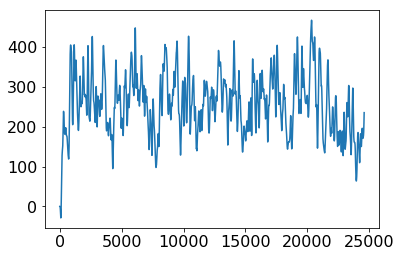

In [ ]:
#Convolve simulated time series with HRF; different shape for each subject & region

#Select HRF parameters and apply them to rest data
inputs = []
for subjNum in subjNumList: inputs.append((subjNum,simulatedTimeseriesTaskStim_inputs_bysubj[:,:,subjNum,1]))
pool = mp.Pool(processes=numWorkers)
output_simulatedTimeseries_convolved_bysubj = pool.map_async(convolveBySubj_varHRF, inputs).get()
pool.close()
pool.join()
    
#Use previously-assigned HRF shape to each region (should be same across rest and tasks)
simulatedTimeseriesTaskStim_convolved=np.ones(np.shape(simulatedTimeseriesTaskStim_inputs))
for taskNum in range(numTasks):
    for regionNum in range(0,numRegions):
        param0=output_simulatedTimeseries_convolved_bysubj[0]['hrfParams_byRegion'][0][regionNum]
        param1=output_simulatedTimeseries_convolved_bysubj[0]['hrfParams_byRegion'][1][regionNum]
        param2=output_simulatedTimeseries_convolved_bysubj[0]['hrfParams_byRegion'][2][regionNum]
        thisRegion_hrf_at_simsample_subj1 = hrf(simsample_times,0.6,param0,param1,param2)
        
        convolved = np.convolve(simulatedTimeseriesTaskStim_inputs[:,regionNum,taskNum], thisRegion_hrf_at_simsample_subj1)
        n_to_remove = len(thisRegion_hrf_at_simsample_subj1) - 1
        convolved = convolved[:-n_to_remove]
        simulatedTimeseriesTaskStim_convolved[:,regionNum,taskNum]=convolved

#For all subjects
simulatedTimeseriesTaskStim_convolved_bysubj=np.ones((np.shape(simulatedTimeseriesTaskStim_inputs_bysubj)))
for subjNum in range(numSubjs):
    for taskNum in range(numTasks):
        for regionNum in range(0,numRegions):
            param0=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][0][regionNum]
            param1=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][1][regionNum]
            param2=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][2][regionNum]
            thisRegion_hrf_at_simsample = hrf(simsample_times,0.6,param0,param1,param2)
            
            convolved = np.convolve(simulatedTimeseriesTaskStim_inputs_bysubj[subjNum,:,regionNum,taskNum], thisRegion_hrf_at_simsample)
            n_to_remove = len(thisRegion_hrf_at_simsample) - 1
            convolved = convolved[:-n_to_remove]
            simulatedTimeseriesTaskStim_convolved_bysubj[subjNum,:,regionNum,taskNum]=convolved

print(np.shape(simulatedTimeseriesTaskStim_convolved))
plt.plot(simulatedTimeseriesTaskStim_convolved[0:,1,0])


noiseLevel (stdev of first subjects first regions timeseries prior to adding MR noise):  75.6407063673
(1640, 300, 3)


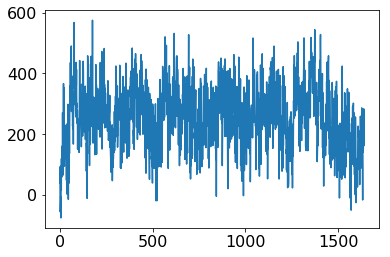

In [ ]:
#Downsample fMRI time series, add noise
TR=0.785
dt_rec=0.05
n_skip_BOLD = int(TR/dt_rec)

BOLD_rec_TaskStim_bysubj = [simulatedTimeseriesTaskStim_convolved_bysubj[subjNum,::n_skip_BOLD,:,:] for subjNum in subjNumList]

#Add Gaussian noise (like MR noise)
noiseLevel=np.std(BOLD_rec_TaskStim_bysubj[0][0:,1,0])
print 'noiseLevel (stdev of first subject''s first region''s timeseries prior to adding MR noise): ',noiseLevel
BOLD_rec_TaskStim_bysubj=BOLD_rec_TaskStim_bysubj+np.random.normal(scale=noiseLevel,size=np.shape(BOLD_rec_TaskStim_bysubj))

BOLD_rec_TaskStim=BOLD_rec_TaskStim_bysubj[0]

print(np.shape(BOLD_rec_TaskStim))
plt.plot(BOLD_rec_TaskStim[0:,1,0])

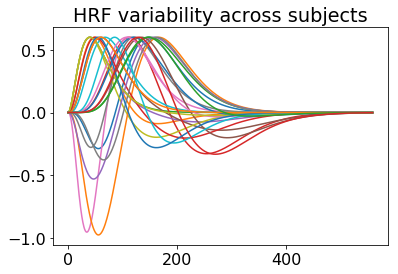

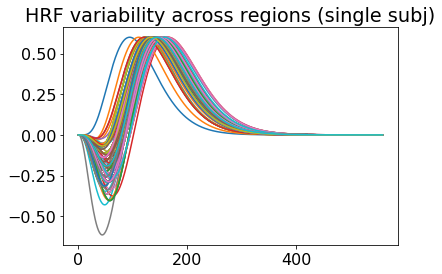

In [ ]:
#Plot HRF variability

for subjNum in range(numSubjs):
    regionNum=0
    param0=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][0][regionNum]
    param1=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][1][regionNum]
    param2=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][2][regionNum]
    thisRegion_hrf_at_simsample = hrf(simsample_times,0.6,param0,param1,param2)
    plt.plot(thisRegion_hrf_at_simsample)
plt.title('HRF variability across subjects')

subjNum=0
plt.figure()
for regionNum in range(0,numRegions):
    param0=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][0][regionNum]
    param1=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][1][regionNum]
    param2=output_simulatedTimeseries_convolved_bysubj[subjNum]['hrfParams_byRegion'][2][regionNum]
    thisRegion_hrf_at_simsample = hrf(simsample_times,0.6,param0,param1,param2)
    plt.plot(thisRegion_hrf_at_simsample)
plt.title('HRF variability across regions (single subj)')

(1640, 5)


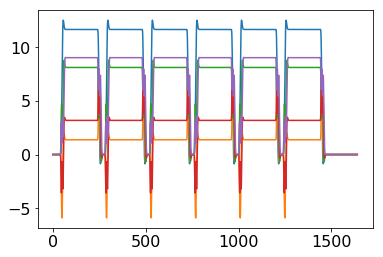

In [ ]:
#Set up basis set for GLM
#Run GLM; get betas and "regress out" stimulation timing
taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1
taskStimTimeseries_convolved=np.zeros((numBasisFunctions,np.shape(taskStimTimeseries)[0]))

#Convolve the basis functions
for i in range(numBasisFunctions):
    convolved = np.convolve(taskStimTimeseries, basisFuncs[i,])
    n_to_remove = len(basisFuncs[i,]) - 1
    convolved = convolved[:-n_to_remove]
    taskStimTimeseries_convolved[i,:]=convolved

#Downsample fMRI time series for design matrix
TR=0.785
dt_rec=0.05
n_skip_BOLD = int(TR/dt_rec)
taskStimTimeseries_rec = taskStimTimeseries_convolved[:,::n_skip_BOLD]
taskStimTimeseries_rec=np.transpose(taskStimTimeseries_rec)
taskStimTimeseries_rec_basis5=taskStimTimeseries_rec[10:,]

print(np.shape(taskStimTimeseries_rec))
plt.plot(taskStimTimeseries_rec)

In [ ]:
#Fit GLM with HRF basis functions

def runGLMBySubj(inputData,designMat,numTimepointsToDrop=10):
    numSubjs=len(inputData)
    numTimepoints=np.shape(inputData[0])[0]-numTimepointsToDrop
    numRegions=np.shape(inputData[0])[1]
    numTasks=np.shape(inputData[0])[2]
    numBetas=np.shape(designMat)[1]-1
    
    GLMBetas_bysubj=np.ones([numSubjs,numRegions,numTasks,numBetas])
    resids_bysubj=np.ones([numSubjs,numTimepoints,numRegions,numTasks])

    for subjNum in range(numSubjs):
        for taskNum in range(numTasks):
            for regionNum in range(numRegions):
                
                y=inputData[subjNum][numTimepointsToDrop:,regionNum,taskNum]
                model = sm.OLS(y, designMat)
                results = model.fit()

                #Save betas
                GLMBetas_bysubj[subjNum,regionNum,taskNum]=results.params[1:numBetas+1]
                #Save residuals
                resids_bysubj[subjNum,:,regionNum,taskNum]=results.resid
    return GLMBetas_bysubj,resids_bysubj

X=taskStimTimeseries_rec[10:,]

#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)

print(np.shape(X))

numTimepoints=np.shape(BOLD_rec_TaskStim)[0]-10

[BOLD_rec_TaskStim_GLMBetas_basis5_bysubj,BOLD_rec_TaskStim_TaskTimeRegressed_bysubj] = runGLMBySubj(BOLD_rec_TaskStim_bysubj,X)

BOLD_rec_TaskStim_GLMBetas_basis5=BOLD_rec_TaskStim_GLMBetas_basis5_bysubj[0,:,:,:]
BOLD_rec_TaskStim_TaskTimeRegressed=BOLD_rec_TaskStim_TaskTimeRegressed_bysubj[0,:,:,:]




(1630, 6)


(1640,)


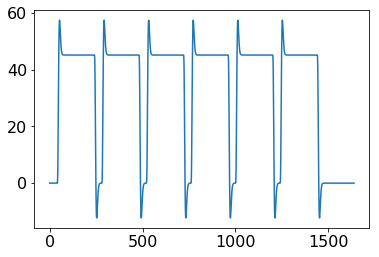

In [ ]:
#Set up canonical regressor for GLM
#Run GLM; get betas and "regress out" stimulation timing
taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1

convolved = np.convolve(taskStimTimeseries, hrf_at_simsample)
n_to_remove = len(hrf_at_simsample) - 1
convolved = convolved[:-n_to_remove]
taskStimTimeseries_convolved=convolved

#Downsample fMRI time series for design matrix
TR=0.785
dt_rec=0.05
n_skip_BOLD = int(TR/dt_rec)
taskStimTimeseries_assumedshape_rec = taskStimTimeseries_convolved[::n_skip_BOLD]

print(np.shape(taskStimTimeseries_assumedshape_rec))
plt.plot(taskStimTimeseries_assumedshape_rec)

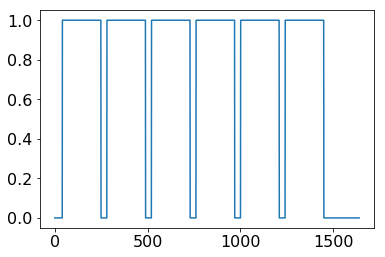

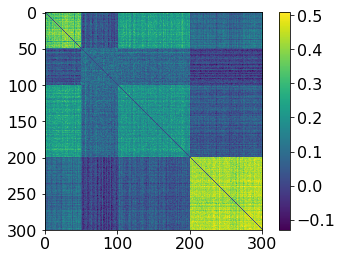

In [ ]:
#Produce task FC matrix based on produced fMRI time series
tasktiming_fMRI=taskStimTimeseries_assumedshape_rec>0
plt.figure()
plt.plot(tasktiming_fMRI)
fcMat_TaskStim=np.corrcoef(BOLD_rec_TaskStim[tasktiming_fMRI,:,0],rowvar=0)
np.fill_diagonal(fcMat_TaskStim,0)
plt.figure()
plt.imshow(fcMat_TaskStim)
plt.colorbar()

#Run for all tasks and subjects
fcMat_TaskStimByTask_bysubj=np.zeros((numSubjs,np.shape(fcMat_TaskStim)[0],np.shape(fcMat_TaskStim)[1],numTasks))
for subjNum in range(numSubjs):
    for taskNum in range(numTasks):
        fcMat_TaskStimByTask_bysubj[subjNum,:,:,taskNum]=np.corrcoef(BOLD_rec_TaskStim_bysubj[subjNum][tasktiming_fMRI,:,taskNum],rowvar=0)

In [ ]:
#Fit GLM with canonical assumed HRF shape (for estimating activation amplitudes)

X=taskStimTimeseries_assumedshape_rec[10:,]

#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)

print(np.shape(X))

numTimepoints=np.shape(BOLD_rec_TaskStim)[0]-10

[BOLD_rec_TaskStim_GLMBetas_bysubj,BOLD_rec_TaskStim_TaskTimeRegressed_AssumedHRFShape_bysubj] = runGLMBySubj(BOLD_rec_TaskStim_bysubj,X)

BOLD_rec_TaskStim_TaskTimeRegressed_AssumedHRFShape=BOLD_rec_TaskStim_TaskTimeRegressed_AssumedHRFShape_bysubj[0,:,:,:]
BOLD_rec_TaskStim_GLMBetas=BOLD_rec_TaskStim_GLMBetas_bysubj[0,:,:]


(1630, 2)


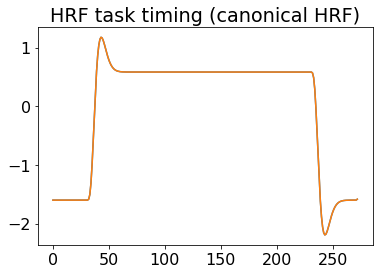

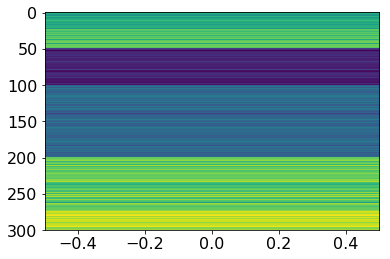

In [ ]:
#HRF-task-timing fMRI data
plt.figure()
plt.plot(stats.zscore(taskStimTimeseries_assumedshape_rec[10:283]))
plt.plot()
plt.plot(stats.zscore(np.mean(BOLD_rec_TaskStim_GLMBetas[0:50,0])*taskStimTimeseries_assumedshape_rec[10:283]))
plt.title("HRF task timing (canonical HRF)")
#plt.savefig('HRFShape_BlockFit_canonicalgHRF.pdf',dpi=600,transparent=True, bbox_inches='tight')

#Betas
plt.figure()
plt.imshow(BOLD_rec_TaskStim_GLMBetas[:,0],aspect='auto')

In [ ]:
#%%time
#FIR modeling, setting up design matrix

timeseriesLength=np.shape(taskStimTimeseries_rec)[0]


#Create FIR regressors
numSecFIRModeledPerEvent=30
numTRsFIRModeledPerEvent=np.rint(numSecFIRModeledPerEvent/TR).astype(int)

#Task timing: stimTimes=np.concatenate((range(600,3600),range(4200,7200),range(7800,10800),range(11400,14400),range(15000,18000),range(18600,21600)),axis=0)
stimDurations=np.multiply([3000,3000,3000,3000,3000,3000],.05)
stimDurations_InTRs=np.rint(np.divide(stimDurations,TR)).astype(int)

#Recalculate task timing using distinct strategy (tricky to convert to fMRI timing)
taskTiming_vector=np.zeros(len(taskStimTimeseries))
taskTiming_vector[stimTimes]=1
taskTiming_vector_BOLDrec=taskTiming_vector[::n_skip_BOLD].astype(int)
taskTiming_BOLDrec=np.nonzero(taskTiming_vector_BOLDrec)[0].astype(int)
taskTiming_vector_BOLDrec_diff=np.diff(taskTiming_vector_BOLDrec)
taskTiming_starts_BOLDrec_ind=np.nonzero(taskTiming_vector_BOLDrec_diff>0)[0]
taskTiming_starts_BOLDrec=taskTiming_starts_BOLDrec_ind.astype(int)
print taskTiming_starts_BOLDrec

#Get onsets of each event
regressorBinaryEvents=np.zeros((np.shape(taskStimTimeseries_rec)[0],))
regressorBinaryEvents[taskTiming_starts_BOLDrec,]=1

#Expand time by durations (assuming all durations are the same)
numTRsFIRModeledPerEvent_withdur=numTRsFIRModeledPerEvent+stimDurations_InTRs[0]

#Set each FIR time point
deconvRegressors=np.zeros((np.shape(taskStimTimeseries_rec)[0],numTRsFIRModeledPerEvent_withdur))
#Set first FIR time point
deconvRegressors[:,0]=regressorBinaryEvents
#Set subsequent FIR time points
for i in range(1,numTRsFIRModeledPerEvent_withdur):
    lag=i
    deconvRegressors[:,i]=np.hstack((np.kron(np.ones((1,lag)),0)[0], regressorBinaryEvents[0:(timeseriesLength-lag),]))


print(np.shape(deconvRegressors))

X=deconvRegressors[10:,]

#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)

print(np.shape(X))

numTimepoints=np.shape(BOLD_rec_TaskStim)[0]-10


[  39  279  519  759  999 1239]
(1640, 229)
(1630, 230)


In [ ]:
#Run FIR model


[BOLD_rec_TaskStim_GLMBetas_Deconv_bysubj,BOLD_rec_TaskStim_FIRTaskTimeRegressed_bysubj] = runGLMBySubj(BOLD_rec_TaskStim_bysubj,X)
    
BOLD_rec_TaskStim_FIRTaskTimeRegressed=BOLD_rec_TaskStim_FIRTaskTimeRegressed_bysubj[0,:,:,:]
BOLD_rec_TaskStim_GLMBetas_Deconv=BOLD_rec_TaskStim_GLMBetas_Deconv_bysubj[0,:,:,:]


print(np.shape(BOLD_rec_TaskStim_GLMBetas_Deconv_bysubj))



(24, 300, 3, 229)


In [ ]:
##Wrong HRF shape test


#Run GLM; get betas and "regress out" stimulation timing
taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim_inputs)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1

convolved_wrongHRF = np.convolve(taskStimTimeseries, hrf_at_simsample_simwrong)
n_to_remove = len(hrf_at_simsample) - 1
convolved_wrongHRF = convolved_wrongHRF[:-n_to_remove]
taskStimTimeseries_convolvedWrongHRF=convolved_wrongHRF

#Downsample fMRI time series for design matrix
TR=0.785
dt_rec=0.05
n_skip_BOLD = int(TR/dt_rec)
taskStimTimeseries_assumedshapeWrongHRF_rec = taskStimTimeseries_convolvedWrongHRF[::n_skip_BOLD]

#Fit GLM with WRONG assumed HRF shape (for estimating activation amplitudes)

X=taskStimTimeseries_assumedshapeWrongHRF_rec[10:,]

#Adding derivative term as well
#derivTS=np.append(np.diff(taskStimTimeseries_rec[10:,]),0)
#X=np.transpose(np.vstack((taskStimTimeseries_rec[10:,],derivTS)))

#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)

print(np.shape(X))

numTimepoints=np.shape(BOLD_rec_TaskStim)[0]-10
[BOLD_rec_TaskStim_GLMBetas_AssumedWrongHRFShape_bysubj,BOLD_rec_TaskStim_TaskTimeRegressed_AssumedWrongHRFShape_bysubj] = runGLMBySubj(BOLD_rec_TaskStim_bysubj,X)

BOLD_rec_TaskStim_TaskTimeRegressed_AssumedWrongHRFShape=BOLD_rec_TaskStim_TaskTimeRegressed_AssumedWrongHRFShape_bysubj[0,:,:,:]
BOLD_rec_TaskStim_GLMBetas_AssumedWrongHRFShape=BOLD_rec_TaskStim_GLMBetas_AssumedWrongHRFShape_bysubj[0,:,:]


(1630, 2)


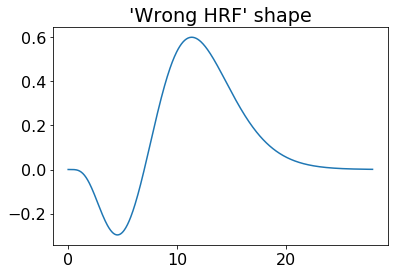

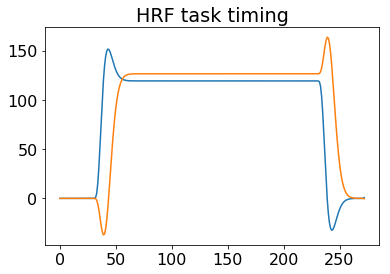

In [ ]:
plt.figure()
plt.plot(simsample_times,hrf_at_simsample_simwrong)
plt.title("'Wrong HRF' shape")
#plt.savefig('HRFShape_WrongHRFShape.pdf',dpi=600,transparent=True, bbox_inches='tight')

#HRF-task-timing fMRI data
canonicalHRFFit=np.mean(BOLD_rec_TaskStim_GLMBetas[0:50,0])*taskStimTimeseries_assumedshape_rec[10:283]
thisFit=np.mean(BOLD_rec_TaskStim_GLMBetas_AssumedWrongHRFShape[0:50,0])*taskStimTimeseries_assumedshapeWrongHRF_rec[10:283]
plt.figure()
plt.plot(canonicalHRFFit)
plt.plot(thisFit)
#plt.plot(canonicalHRFFit-thisFit)
plt.title("HRF task timing")
#plt.savefig('HRFShape_BlockFit_WrongHRF.pdf',dpi=600,transparent=True, bbox_inches='tight')

In [ ]:

def createFCMatBySubj_SingleTask(timeseriesData,taskNum,taskTiming):
    subjNumList=range(len(timeseriesData))
    return [np.corrcoef(timeseriesData[subjNum][taskTiming,:,taskNum],rowvar=0) for subjNum in subjNumList]


## Assumed-shape HRF version

#Produce task FC matrix based on produced fMRI time series, AFTER REGRESSING out task timing
fcMat_TaskStim_TaskTimeRegressed_AssumedHRFShape_bysubj=createFCMatBySubj_SingleTask(BOLD_rec_TaskStim_TaskTimeRegressed_AssumedHRFShape_bysubj,0,tasktiming_fMRI[10:])
fcMat_TaskStim_TaskTimeRegressed_AssumedHRFShape=fcMat_TaskStim_TaskTimeRegressed_AssumedHRFShape_bysubj[0]


#Run for all tasks
fcMat_TaskStim_TaskTimeRegressedByTask_AssumedHRFShape=[createFCMatBySubj_SingleTask(BOLD_rec_TaskStim_TaskTimeRegressed_AssumedHRFShape_bysubj,taskNum,tasktiming_fMRI[10:]) for taskNum in range(numTasks)]



## With no task regression

#Run for all tasks
fcMat_TaskStim_NOTaskTimeRegressedByTask=[createFCMatBySubj_SingleTask(BOLD_rec_TaskStim_bysubj,taskNum,tasktiming_fMRI) for taskNum in range(numTasks)]






## With wrong HRF shape
#Run for all tasks
fcMat_TaskStim_TaskTimeRegressedByTask_WrongHRF=[createFCMatBySubj_SingleTask(BOLD_rec_TaskStim_TaskTimeRegressed_AssumedWrongHRFShape_bysubj,taskNum,tasktiming_fMRI[10:]) for taskNum in range(numTasks)]

    
## With FIR
#Run for all tasks
fcMat_TaskStim_TaskTimeRegressedByTask_FIR=[createFCMatBySubj_SingleTask(BOLD_rec_TaskStim_FIRTaskTimeRegressed_bysubj,taskNum,tasktiming_fMRI[10:]) for taskNum in range(numTasks)]
fcMat_TaskStim_TaskTimeRegressed_FIR=fcMat_TaskStim_TaskTimeRegressedByTask_FIR[0][0]
np.fill_diagonal(fcMat_TaskStim_TaskTimeRegressed_FIR,0)

## Using HRF basis set:
fcMat_TaskStim_TaskTimeRegressedByTask=[createFCMatBySubj_SingleTask(BOLD_rec_TaskStim_TaskTimeRegressed_bysubj,taskNum,tasktiming_fMRI[10:]) for taskNum in range(numTasks)]
fcMat_TaskStim_TaskTimeRegressed=fcMat_TaskStim_TaskTimeRegressedByTask[0][0]
#Produce task FC matrix based on produced fMRI time series, AFTER REGRESSING out task timing
# fig=plt.figure()
# fig.suptitle("Task regressed with HRF basis set")
np.fill_diagonal(fcMat_TaskStim_TaskTimeRegressed,0)
# plt.imshow(fcMat_TaskStim_TaskTimeRegressed)
# plt.colorbar()




In [ ]:
#Calculate t-tests for fMRI FC
#Task0 vs rest, canonical HRF
[fcMat_tvals_t0vsRest,fcMat_pvals_t0vsRest]=ttestFCByRegion(fcMat_TaskStim_TaskTimeRegressedByTask_AssumedHRFShape[0],fcMat_TaskStim_TaskTimeRegressedByTask_AssumedHRFShape[1])
fcMat_rvaldiff_t0vsRest_canonicalHRFReg=np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_AssumedHRFShape[0],axis=0)-np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_AssumedHRFShape[1],axis=0)
#Task0 vs rest, no HRF regression
[fcMat_tvals_t0vsRest_noHRFreg,fcMat_pvals_t0vsRest_noHRFreg]=ttestFCByRegion(fcMat_TaskStim_NOTaskTimeRegressedByTask[0],fcMat_TaskStim_NOTaskTimeRegressedByTask[1])
fcMat_rvaldiff_t0vsRest_noHRFreg=np.mean(fcMat_TaskStim_NOTaskTimeRegressedByTask[0],axis=0)-np.mean(fcMat_TaskStim_NOTaskTimeRegressedByTask[1],axis=0)
#Wrong HRF-shape regression
[fcMat_tvals_t0vsRest_WrongHRFreg,fcMat_pvals_t0vsRest_WrongHRFreg]=ttestFCByRegion(fcMat_TaskStim_TaskTimeRegressedByTask_WrongHRF[0],fcMat_TaskStim_TaskTimeRegressedByTask_WrongHRF[1])
fcMat_rvaldiff_t0vsRest_WrongHRFreg=np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_WrongHRF[0],axis=0)-np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_WrongHRF[1],axis=0)
#FIR regression
[fcMat_tvals_t0vsRest_FIRreg,fcMat_pvals_t0vsRest_FIRreg]=ttestFCByRegion(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[0],fcMat_TaskStim_TaskTimeRegressedByTask_FIR[1])
fcMat_rvaldiff_t0vsRest_FIRreg=np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[0],axis=0)-np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[1],axis=0)
#Task0 vs rest, basis set HRF
[fcMat_tvals_t0vsRest_basis,fcMat_pvals_t0vsRest_basis]=ttestFCByRegion(fcMat_TaskStim_TaskTimeRegressedByTask[0],fcMat_TaskStim_TaskTimeRegressedByTask[1])
fcMat_rvaldiff_t0vsRest_basis=np.mean(fcMat_TaskStim_TaskTimeRegressedByTask[0],axis=0)-np.mean(fcMat_TaskStim_TaskTimeRegressedByTask[1],axis=0)

#Task0 vs task2, basis set HRF
[fcMat_tvals_t0vst2_basis,fcMat_pvals_t0vst2_basis]=ttestFCByRegion(fcMat_TaskStim_TaskTimeRegressedByTask[0],fcMat_TaskStim_TaskTimeRegressedByTask[2])
fcMat_rvaldiff_t0vst2_basis=np.mean(fcMat_TaskStim_TaskTimeRegressedByTask[0],axis=0)-np.mean(fcMat_TaskStim_TaskTimeRegressedByTask[2],axis=0)
#FIR regression
[fcMat_tvals_t0vst2_FIRreg,fcMat_pvals_t0vst2_FIRreg]=ttestFCByRegion(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[0],fcMat_TaskStim_TaskTimeRegressedByTask_FIR[2])
fcMat_rvaldiff_t0vst2_FIRreg=np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[0],axis=0)-np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[2],axis=0)

#Pre-fMRI no task regression
fcMat_taskActFC_preFMRI_bysubj_task0=fcMat_taskActFC_preFMRI_bysubj_bytask[0]
[fcMat_tvals_t0vsRest_PrefMRINoTaskReg,fcMat_pvals_t0vsRest_PrefMRINoTaskReg]=ttestFCByRegion(fcMat_taskActFC_preFMRI_bysubj_bytask[0],fcMat_taskActFC_preFMRI_bysubj_bytask[1])
fcMat_rvaldiff_t0vsRest_PrefMRINoTaskReg=np.mean(fcMat_taskActFC_preFMRI_bysubj_bytask[0],axis=0)-np.mean(fcMat_taskActFC_preFMRI_bysubj_bytask[1],axis=0)
#Pre-fMRI with task regression

#Run GLM; get betas and "regress out" stimulation timing
taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim_inputs)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1
X=taskStimTimeseries[10:]
#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)
numTimepoints=np.shape(taskStimTimeseries)[0]
[TaskStim_PrefMRI_GLMBetas_bysubj,TaskStim_PrefMRI_TaskTimeRegressed_bysubj] = runGLMBySubj(simulatedTimeseriesTaskStim_inputs_bysubj,X)

fcMat_TaskStim__PrefMRITaskReg=[createFCMatBySubj_SingleTask(TaskStim_PrefMRI_TaskTimeRegressed_bysubj,taskNum,stimTimes) for taskNum in range(numTasks)]
[fcMat_tvals_t0vsRest_PrefMRITaskReg,fcMat_pvals_t0vsRest_PrefMRITaskReg]=ttestFCByRegion(fcMat_TaskStim__PrefMRITaskReg[0],fcMat_TaskStim__PrefMRITaskReg[1])
fcMat_rvaldiff_t0vsRest_PrefMRITaskReg=np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0)-np.mean(fcMat_TaskStim__PrefMRITaskReg[1],axis=0)


In [ ]:
#Comparing fMRI FC matrices to pre-fMRI
#(Better removal of fMRI-induced artifact should make an FC matrix more similar to pre-fMRI)

upperTIndices=np.triu_indices(np.shape(fcMat_pvals_t0vsRest)[0],k=1)
#[0:200,200:300].reshape(200*100)

#Comparing no-task-regression to pre-fMRI task0
rvalFCMatComp_prefMRI_fMRINoTaskReg=np.corrcoef(np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0)[upperTIndices],np.mean(fcMat_TaskStim_NOTaskTimeRegressedByTask[0],axis=0)[upperTIndices])[0,1]
print 'rvalFCMatComp_prefMRI_fMRINoTaskReg: ', rvalFCMatComp_prefMRI_fMRINoTaskReg

rvalFCMatComp_prefMRI_fMRIWrongHRFTaskReg=np.corrcoef(np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0)[upperTIndices],np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_WrongHRF[0],axis=0)[upperTIndices])[0,1]
print 'rvalFCMatComp_prefMRI_fMRIWrongHRFTaskReg: ', rvalFCMatComp_prefMRI_fMRIWrongHRFTaskReg

rvalFCMatComp_prefMRI_fMRIFIRTaskReg=np.corrcoef(np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0)[upperTIndices],np.mean(fcMat_TaskStim_TaskTimeRegressedByTask_FIR[0],axis=0)[upperTIndices])[0,1]
print 'rvalFCMatComp_prefMRI_fMRIFIRTaskReg: ', rvalFCMatComp_prefMRI_fMRIFIRTaskReg

rvalFCMatComp_prefMRI_fMRIBasisTaskReg=np.corrcoef(np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0)[upperTIndices],np.mean(fcMat_TaskStim_TaskTimeRegressedByTask[0],axis=0)[upperTIndices])[0,1]
print 'rvalFCMatComp_prefMRI_fMRIBasisTaskReg: ', rvalFCMatComp_prefMRI_fMRIBasisTaskReg

#plt.scatter(np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0)[upperTIndices],np.mean(fcMat_TaskStim_NOTaskTimeRegressedByTask[0],axis=0)[upperTIndices])
#plt.imshow(np.mean(fcMat_TaskStim__PrefMRITaskReg[0],axis=0))
#plt.colorbar()

rvalFCMatComp_prefMRI_fMRINoTaskReg:  0.977445304013
rvalFCMatComp_prefMRI_fMRIWrongHRFTaskReg:  0.985927448478
rvalFCMatComp_prefMRI_fMRIFIRTaskReg:  0.990066792844
rvalFCMatComp_prefMRI_fMRIBasisTaskReg:  0.990221239558


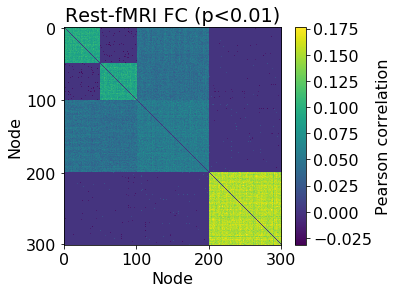

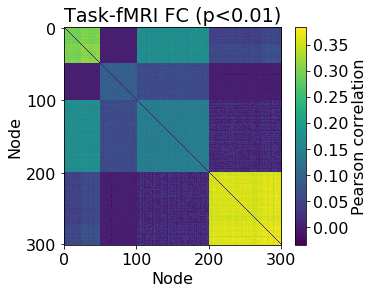

In [ ]:
#Visualize resting-state network structure (with same timing as task, just no task stimulation)

plt.figure(figsize=(5,4))
[fcMat_tvals_fMRITaskTiming_Restvs0,fcMat_pvals_fMRITaskTiming_Restvs0]=ttestFCByRegionVs0(fcMat_TaskStim_NOTaskTimeRegressedByTask[1])
restFCMat_tasktiming_mean_p01=np.mean(fcMat_TaskStim_NOTaskTimeRegressedByTask[1],axis=0)*(fcMat_pvals_fMRITaskTiming_Restvs0<0.01)
np.fill_diagonal(restFCMat_tasktiming_mean_p01,0)
plt.imshow(restFCMat_tasktiming_mean_p01)
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("Rest-fMRI FC (p<0.01)")
plt.savefig('300Nodes_restFCfMRISimP01_tasktiming.pdf',dpi=600,transparent=True, bbox_inches='tight')

plt.figure(figsize=(5,4))
[fcMat_tvals_fMRITaskTiming_Taskvs0,fcMat_pvals_fMRITaskTiming_Taskvs0]=ttestFCByRegionVs0(fcMat_TaskStim_NOTaskTimeRegressedByTask[0])
taskFCMat_tasktiming_mean_p01=np.mean(fcMat_TaskStim_NOTaskTimeRegressedByTask[0],axis=0)*(fcMat_pvals_fMRITaskTiming_Taskvs0<0.01)
np.fill_diagonal(taskFCMat_tasktiming_mean_p01,0)
plt.imshow(taskFCMat_tasktiming_mean_p01)
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("Task-fMRI FC (p<0.01)")
plt.savefig('300Nodes_taskFCfMRISimP01_tasktiming.pdf',dpi=600,transparent=True, bbox_inches='tight')


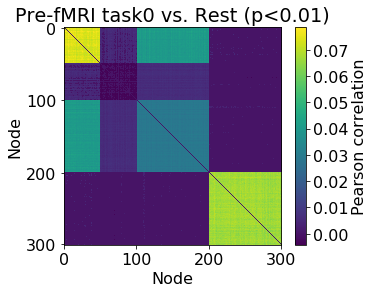

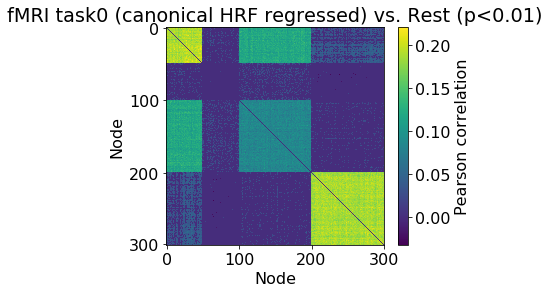

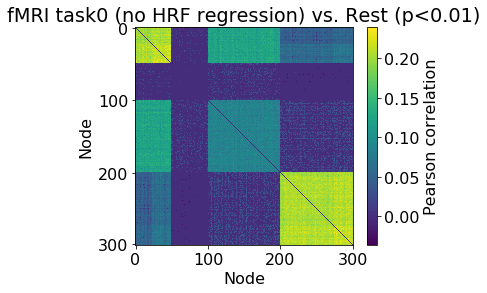

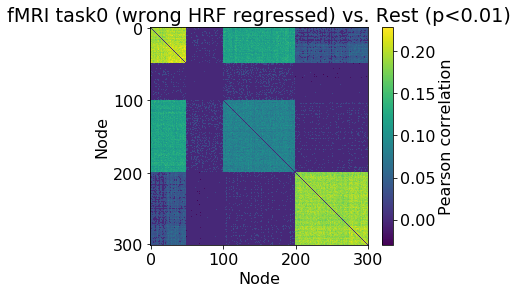

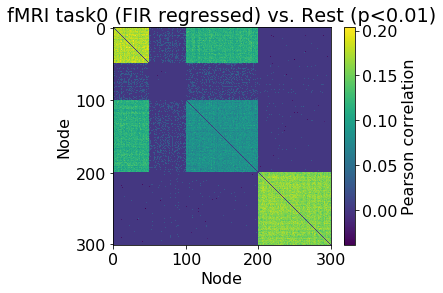

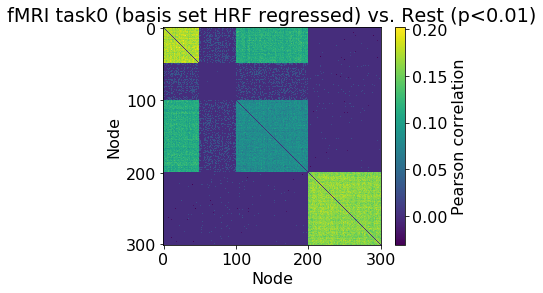

In [ ]:

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vsRest_PrefMRITaskReg*(fcMat_pvals_t0vsRest_PrefMRITaskReg<0.01))
plt.title("Pre-fMRI task0 vs. Rest (p<0.01)")
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.savefig('FCMat_Task0vsRestfMRI_pPt01Thresh_prefMRITaskReg.pdf',dpi=600,transparent=True, bbox_inches='tight')

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vsRest_canonicalHRFReg*(fcMat_pvals_t0vsRest<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (canonical HRF regressed) vs. Rest (p<0.01)")
plt.savefig('FCMat_Task0vsRestfMRI_pPt01Thresh_canonicalHRFTaskReg.pdf',dpi=600,transparent=True, bbox_inches='tight')

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vsRest_noHRFreg*(fcMat_pvals_t0vsRest_noHRFreg<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (no HRF regression) vs. Rest (p<0.01)")
plt.savefig('FCMat_Task0vsRestfMRI_pPt01Thresh_NoTaskReg.pdf',dpi=600,transparent=True, bbox_inches='tight')

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vsRest_WrongHRFreg*(fcMat_pvals_t0vsRest_WrongHRFreg<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (wrong HRF regressed) vs. Rest (p<0.01)")
plt.savefig('FCMat_Task0vsRestfMRI_pPt01Thresh_WrongHRFTaskReg.pdf',dpi=600,transparent=True, bbox_inches='tight')

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vsRest_FIRreg*(fcMat_pvals_t0vsRest_FIRreg<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (FIR regressed) vs. Rest (p<0.01)")
plt.savefig('FCMat_Task0vsRestfMRI_pPt01Thresh_FIRTaskReg.pdf',dpi=600,transparent=True, bbox_inches='tight')

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vsRest_basis*(fcMat_pvals_t0vsRest_basis<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (basis set HRF regressed) vs. Rest (p<0.01)")
plt.savefig('FCMat_Task0vsRestfMRI_pPt01Thresh_BasissetHRFTaskReg.pdf',dpi=600,transparent=True, bbox_inches='tight')





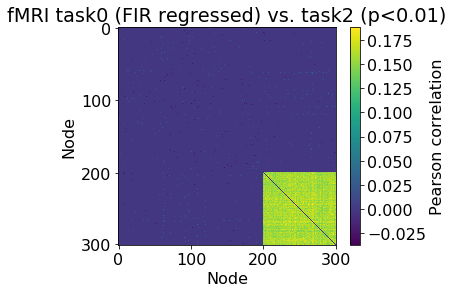

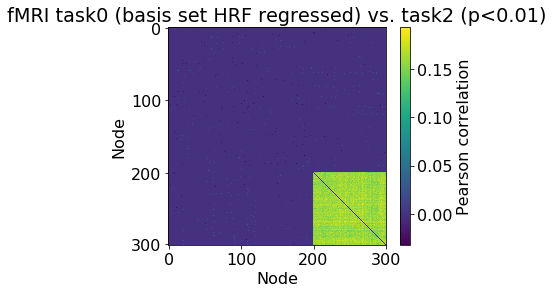

In [ ]:
#Task0 vs. Task2

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vst2_FIRreg*(fcMat_pvals_t0vst2_FIRreg<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (FIR regressed) vs. task2 (p<0.01)")

plt.figure(figsize=(5,4))
plt.imshow(fcMat_rvaldiff_t0vst2_basis*(fcMat_pvals_t0vst2_basis<0.01))
cbar=plt.colorbar()
cbar.set_label('Pearson correlation')
plt.xlabel('Node')
plt.ylabel('Node')
plt.yticks(np.append(np.arange(0,numRegions,100), np.array(numRegions-1)))
ax = plt.gca();
ax.set_yticklabels(np.append(np.arange(0,numRegions,100), np.array(numRegions)))
plt.title("fMRI task0 (basis set HRF regressed) vs. task2 (p<0.01)")


In [ ]:
#Testing for false positives/negatives for fMRI relative to pre-fMRI data

upperTIndices=np.triu_indices(np.shape(fcMat_pvals_t0vsRest)[0],k=1)

#canonical HRF regression - Check for false positives/negatives for fMRI (relative to pre-fMRI)
fcMat_pvals_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest[upperTIndices]<0.01)*1
#fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRITaskReg[upperTIndices]<0.01)*1
fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRINoTaskReg[upperTIndices]<0.01)*1
falsePos=sum((fcMat_pvals_t0vsRest_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)>0)
falseNeg=sum((fcMat_pvals_t0vsRest_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)<0)
falseNeg_CanonHRF=100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)
print('False positives (comparing fMRI-CanonicalHRF to pre-fMRI, task0 vs. rest):' + str(falsePos) + ' (' + str(100.00*falsePos/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')
print('False negatives (comparing fMRI-CanonicalHRF to pre-fMRI, task0 vs. rest):' + str(falseNeg) + ' (' + str(100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')

#No HRF regression - Check for false positives/negatives for fMRI (relative to pre-fMRI)
fcMat_pvals_t0vsRest_noHRFreg_upperTThresh=(fcMat_pvals_t0vsRest_noHRFreg[upperTIndices]<0.01)*1
fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRINoTaskReg[upperTIndices]<0.01)*1
falsePos=sum((fcMat_pvals_t0vsRest_noHRFreg_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)>0)
falseNeg=sum((fcMat_pvals_t0vsRest_noHRFreg_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)<0)
falseNeg_NoHRF=100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)
print('False positives (comparing fMRI-noHRFreg to pre-fMRI, task0 vs. rest):' + str(falsePos) + ' (' + str(100.00*falsePos/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')
print('False negatives (comparing fMRI-noHRFreg to pre-fMRI, task0 vs. rest):' + str(falseNeg) + ' (' + str(100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')

#Wrong HRF
fcMat_pvals_t0vsRest_wrongHRF_upperTThresh=(fcMat_pvals_t0vsRest_WrongHRFreg[upperTIndices]<0.01)*1
fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRINoTaskReg[upperTIndices]<0.01)*1
falsePos=sum((fcMat_pvals_t0vsRest_wrongHRF_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)>0)
falseNeg=sum((fcMat_pvals_t0vsRest_wrongHRF_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)<0)
falseNeg_wrongHRF=100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)
print('False positives (comparing fMRI-wrongHRF to pre-fMRI, task0 vs. rest):' + str(falsePos) + ' (' + str(100.00*falsePos/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')
print('False negatives (comparing fMRI-wrongHRF to pre-fMRI, task0 vs. rest):' + str(falseNeg) + ' (' + str(100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')

#FIR regression
fcMat_pvals_t0vsRest_FIRreg_upperTThresh=(fcMat_pvals_t0vsRest_FIRreg[upperTIndices]<0.01)*1
fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRINoTaskReg[upperTIndices]<0.01)*1
falsePos=sum((fcMat_pvals_t0vsRest_FIRreg_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)>0)
falseNeg=sum((fcMat_pvals_t0vsRest_FIRreg_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)<0)
falseNeg_FIRReg=100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)
print('False positives (comparing fMRI-FIRreg to pre-fMRI, task0 vs. rest):' + str(falsePos) + ' (' + str(100.00*falsePos/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')
print('False negatives (comparing fMRI-FIRreg to pre-fMRI, task0 vs. rest):' + str(falseNeg) + ' (' + str(100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')

#Basis HRF regression - Check for false positives/negatives for fMRI (relative to pre-fMRI)
fcMat_pvals_t0vsRest_basis_upperTThresh=(fcMat_pvals_t0vsRest_basis[upperTIndices]<0.01)*1
fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRINoTaskReg[upperTIndices]<0.01)*1
falsePos=sum((fcMat_pvals_t0vsRest_basis_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)>0)
falseNeg=sum((fcMat_pvals_t0vsRest_basis_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)<0)
falseNeg_BasisSetReg=100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)
print('False positives (comparing fMRI-basis to pre-fMRI, task0 vs. rest):' + str(falsePos) + ' (' + str(100.00*falsePos/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')
print('False negatives (comparing fMRI-basis to pre-fMRI, task0 vs. rest):' + str(falseNeg) + ' (' + str(100.00*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')


False positives (comparing fMRI-CanonicalHRF to pre-fMRI, task0 vs. rest):3953 (8.8138238573%)
False negatives (comparing fMRI-CanonicalHRF to pre-fMRI, task0 vs. rest):6439 (14.3567447046%)
False positives (comparing fMRI-noHRFreg to pre-fMRI, task0 vs. rest):8193 (18.2675585284%)
False negatives (comparing fMRI-noHRFreg to pre-fMRI, task0 vs. rest):6713 (14.9676700111%)
False positives (comparing fMRI-wrongHRF to pre-fMRI, task0 vs. rest):5015 (11.1817168339%)
False negatives (comparing fMRI-wrongHRF to pre-fMRI, task0 vs. rest):6583 (14.6778149387%)
False positives (comparing fMRI-FIRreg to pre-fMRI, task0 vs. rest):313 (0.697881828317%)
False negatives (comparing fMRI-FIRreg to pre-fMRI, task0 vs. rest):6235 (13.9018952062%)
False positives (comparing fMRI-basis to pre-fMRI, task0 vs. rest):332 (0.740245261984%)
False negatives (comparing fMRI-basis to pre-fMRI, task0 vs. rest):5974 (13.3199554069%)


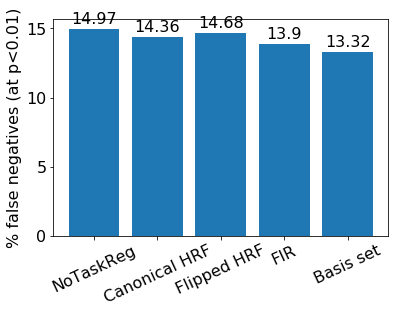

In [ ]:
#Plot bar plot of false negatives

fig,ax = plt.subplots()
xLabels=("NoTaskReg","Canonical HRF","Flipped HRF","FIR","Basis set")
y_pos=np.arange(len(xLabels))
yVals=[falseNeg_NoHRF,falseNeg_CanonHRF,falseNeg_wrongHRF,falseNeg_FIRReg,falseNeg_BasisSetReg]
rects=ax.bar(y_pos,yVals,align='center')
plt.xticks(y_pos,xLabels)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=25)
plt.ylabel('% false negatives (at p<0.01)')
# prefMRIPlot, = plt.plot(0, falsePosPerc_prefMRI, 'o', label="Pre-fMRI NoTaskReg")
# fMRINoTaskReg, = plt.plot(1, falsePosPerc_noHRFreg, 'o', label="fMRI NoTaskReg")
# plt.legend(handles=[prefMRIPlot, fMRINoTaskReg])
# plt.show()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                round(height,2),
                ha='center', va='bottom')
        
autolabel(rects)

plt.savefig('FalseNegBarPlot.pdf',dpi=600,transparent=True, bbox_inches='tight')


In [ ]:
#Calculating false positives from 0-connectivity portion of graph

def calcFalsePosVals(fcMat_pvals):
    fcMat_pvals_zeroConnThresh=(fcMat_pvals[0:200,200:300].reshape(200*100)<0.01)*1
    falsePos=sum(fcMat_pvals_zeroConnThresh>0)
    falsePosPerc=100.00*falsePos/len(fcMat_pvals_zeroConnThresh)
    return falsePos,falsePosPerc


#Pre-fMRI no task regression - Check for false positives for fMRI
[falsePos,falsePosPerc_prefMRI]=calcFalsePosVals(fcMat_pvals_t0vsRest_PrefMRINoTaskReg)
#[falsePos,falsePosPerc_prefMRI]=calcFalsePosVals(fcMat_pvals_t0vsRest_PrefMRITaskReg)
print('False positives (Pre-fMRI-NoTaskReg for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_prefMRI,2)) + '%)')

#No HRF regression - Check for false positives for fMRI
[falsePos,falsePosPerc_noHRFreg]=calcFalsePosVals(fcMat_pvals_t0vsRest_noHRFreg)
print('False positives (fMRI-NoHRFRegression for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_noHRFreg,2)) + '%)')

#canonical HRF regression - Check for false positives for fMRI
[falsePos,falsePosPerc_CorrHRFReg]=calcFalsePosVals(fcMat_pvals_t0vsRest)
print('False positives (fMRI-CanonicalHRF for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_CorrHRFReg,2)) + '%)')

#Wrong HRF shape regression - Check for false positives for fMRI
[falsePos,falsePosPerc_WrongHRFReg]=calcFalsePosVals(fcMat_pvals_t0vsRest_WrongHRFreg)
print('False positives (fMRI-WrongHRFShape for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_WrongHRFReg,2)) + '%)')

#FIR regression
[falsePos,falsePosPerc_FIRReg]=calcFalsePosVals(fcMat_pvals_t0vsRest_FIRreg)
print('False positives (fMRI-FIRReg for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_FIRReg,2)) + '%)')

#Basis set regression
[falsePos,falsePosPerc_basisset]=calcFalsePosVals(fcMat_pvals_t0vsRest_basis)
print('False positives (fMRI-BasisSet for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_basisset,2)) + '%)')

#Resting-state FC (task timing)
[falsePos,falsePosPerc_restFC]=calcFalsePosVals(fcMat_pvals_fMRITaskTiming_Restvs0)
print('False positives (fMRI-restFC for 0-connectivity zone, rest vs. 0):' + str(falsePos) + ' (' + str(round(falsePosPerc_restFC,2)) + '%)')


#Task FC vs 0 (no task regression)
[falsePos,falsePosPerc_taskFCvs0]=calcFalsePosVals(fcMat_pvals_fMRITaskTiming_Taskvs0)
print('False positives (fMRI-taskFC noregression for 0-connectivity zone, task vs. 0):' + str(falsePos) + ' (' + str(round(falsePosPerc_taskFCvs0,2)) + '%)')


#Basis set regression - t0 vs. t2
[falsePos,falsePosPerc_basisset_t0vst2]=calcFalsePosVals(fcMat_pvals_t0vst2_basis)
print('False positives (fMRI-BasisSet for 0-connectivity zone, task0 vs. task2):' + str(falsePos) + ' (' + str(round(falsePosPerc_basisset_t0vst2,2)) + '%)')

#FIR regression  - t0 vs. t2
[falsePos,falsePosPerc_FIRReg_t0vst2]=calcFalsePosVals(fcMat_pvals_t0vst2_FIRreg)
print('False positives (fMRI-FIRReg for 0-connectivity zone, task0 vs. task2):' + str(falsePos) + ' (' + str(round(falsePosPerc_FIRReg_t0vst2,2)) + '%)')


False positives (Pre-fMRI-NoTaskReg for 0-connectivity zone, task0 vs. rest):397 (1.99%)
False positives (fMRI-NoHRFRegression for 0-connectivity zone, task0 vs. rest):8416 (42.08%)
False positives (fMRI-CanonicalHRF for 0-connectivity zone, task0 vs. rest):4061 (20.3%)
False positives (fMRI-WrongHRFShape for 0-connectivity zone, task0 vs. rest):5157 (25.79%)
False positives (fMRI-FIRReg for 0-connectivity zone, task0 vs. rest):241 (1.21%)
False positives (fMRI-BasisSet for 0-connectivity zone, task0 vs. rest):242 (1.21%)
False positives (fMRI-restFC for 0-connectivity zone, rest vs. 0):235 (1.18%)
False positives (fMRI-taskFC noregression for 0-connectivity zone, task vs. 0):10671 (53.35%)
False positives (fMRI-BasisSet for 0-connectivity zone, task0 vs. task2):167 (0.83%)
False positives (fMRI-FIRReg for 0-connectivity zone, task0 vs. task2):175 (0.88%)


In [ ]:
print('False positives for stimulation of just first and third communities (not first and 4th)')

#No HRF regression - Check for false positives for fMRI
[fcMat_tvals_t0vsRest_noHRFregT3,fcMat_pvals_t0vsRest_noHRFregT3]=ttestFCByRegion(fcMat_TaskStim_NOTaskTimeRegressedByTask[2],fcMat_TaskStim_NOTaskTimeRegressedByTask[1])
[falsePos,falsePosPerc_noHRFregT3]=calcFalsePosVals(fcMat_pvals_t0vsRest_noHRFregT3)
print('False positives (fMRI-NoHRFRegressionT3 for 0-connectivity zone, task0 vs. rest):' + str(falsePos) + ' (' + str(round(falsePosPerc_noHRFregT3,2)) + '%)')



False positives for stimulation of just first and third communities (not first and 4th)
False positives (fMRI-NoHRFRegressionT3 for 0-connectivity zone, task0 vs. rest):212 (1.06%)


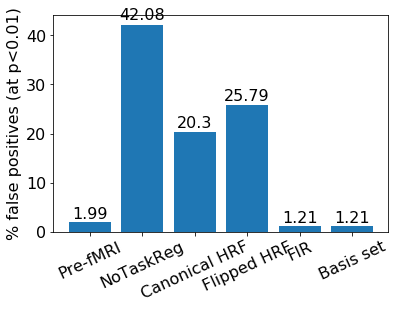

In [ ]:
#Plot bar plot of false positives

fig,ax = plt.subplots()
xLabels=("Pre-fMRI","NoTaskReg","Canonical HRF","Flipped HRF","FIR","Basis set")
y_pos=np.arange(len(xLabels))
yVals=[falsePosPerc_prefMRI,falsePosPerc_noHRFreg,falsePosPerc_CorrHRFReg,falsePosPerc_WrongHRFReg,falsePosPerc_FIRReg,falsePosPerc_basisset]
rects=ax.bar(y_pos,yVals,align='center')
plt.xticks(y_pos,xLabels)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=25)
plt.ylabel('% false positives (at p<0.01)')
# prefMRIPlot, = plt.plot(0, falsePosPerc_prefMRI, 'o', label="Pre-fMRI NoTaskReg")
# fMRINoTaskReg, = plt.plot(1, falsePosPerc_noHRFreg, 'o', label="fMRI NoTaskReg")
# plt.legend(handles=[prefMRIPlot, fMRINoTaskReg])
# plt.show()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                round(height,2),
                ha='center', va='bottom')
        
autolabel(rects)

plt.savefig('FalsePosBarPlot.pdf',dpi=600,transparent=True, bbox_inches='tight')


In [ ]:

#Testing with no HRF, just downsampling
TR=0.785
#TR=0.1
dt_rec=0.05
n_skip_BOLD = int(TR/dt_rec)

taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim_inputs)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1
stimTimes_rec=taskStimTimeseries[::n_skip_BOLD]>0

simulatedTimeseriesTaskStim_noHRF_taskReg_bysubj_rec=[TaskStim_PrefMRI_TaskTimeRegressed_bysubj[subjNum,::n_skip_BOLD,:,:] for subjNum in range(numSubjs)]
fcMat_noHRF_task0_bysubj=createFCMatBySubj_SingleTask(simulatedTimeseriesTaskStim_noHRF_taskReg_bysubj_rec,0,stimTimes_rec)
fcMat_rest_noHRF_bysubj=createFCMatBySubj_SingleTask(simulatedTimeseriesTaskStim_noHRF_taskReg_bysubj_rec,1,stimTimes_rec)
#fcMat_rest_noHRF_bysubj=[np.corrcoef(simulatedRestTimeseries_noHRF_bysubj_rec[subjNum][10:,],rowvar=0) for subjNum in subjNumList]

#plt.imshow(fcMat_noHRF_task0_bysubj[0]-fcMat_rest_noHRF_bysubj[0])
#plt.hist([fcMat_noHRF_task0_bysubj[subjNum][40,50] for subjNum in subjNumList])

#Task0 vs rest, basis set HRF
[fcMat_tvals_t0vsRest_noHRF,fcMat_pvals_t0vsRest_noHRF]=ttestFCByRegion(fcMat_noHRF_task0_bysubj,fcMat_rest_noHRF_bysubj)

fcMat_pvals_t0vsRest_noHRF_upperTThresh=(fcMat_pvals_t0vsRest_noHRF[upperTIndices]<0.01)*1
fcMat_pvals_PrefMRI_t0vsRest_upperTThresh=(fcMat_pvals_t0vsRest_PrefMRITaskReg[upperTIndices]<0.01)*1
falsePos=sum((fcMat_pvals_t0vsRest_noHRF_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)>0)
falseNeg=sum((fcMat_pvals_t0vsRest_noHRF_upperTThresh-fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)<0)
print('False positives (comparing fMRI-noHRF to pre-fMRI, task0 vs. rest):' + str(falsePos) + ' (' + str(100*falsePos/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')
print('False negatives (comparing fMRI-noHRF to pre-fMRI, task0 vs. rest):' + str(falseNeg) + ' (' + str(100*falseNeg/len(fcMat_pvals_PrefMRI_t0vsRest_upperTThresh)) + '%)')



False positives (comparing fMRI-noHRF to pre-fMRI, task0 vs. rest):335 (0%)
False negatives (comparing fMRI-noHRF to pre-fMRI, task0 vs. rest):2952 (6%)


In [ ]:
sm.show_versions()


INSTALLED VERSIONS
------------------
Python: 2.7.13.final.0
OS: Linux 3.10.0-327.28.2.el7.x86_64 #1 SMP Wed Aug 3 11:11:39 UTC 2016 x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8

Statsmodels

Installed: 0.8.0 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/statsmodels)

Required Dependencies

cython: Not installed
numpy: 1.12.1 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/numpy)
scipy: 0.19.0 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/scipy)
pandas: 0.19.2 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/pandas)
    dateutil: 2.6.0 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/dateutil)
patsy: 0.4.1 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/patsy)

Optional Dependencies

matplotlib: 2.0.0 (/home/mwcole/anaconda2/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib)
cvxopt: Not installed

Developer Tools

IPython: 5.3.0